SUMME DER AUSLEIHEN(A) UND RÜCKGABEN(R) AN EINER STATION AM TAG t

In [1]:
from datetime import datetime, date
import pandas as pd
import csv
import numpy as np 
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import pmdarima as pm
from pmdarima.arima import ADFTest
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

In c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed tw

Ausgangsdaten der Ausleihen und Rückgaben für die Station 'Grove St PATH' von 2018-01-01 bis 2022-02-28

In [2]:
data_A = pd.read_csv(r'C:\Users\emres\OneDrive\BA\Data\bike_station_A_final.csv')
data_R = pd.read_csv(r'C:\Users\emres\OneDrive\BA\Data\bike_station_R_final.csv')

In [3]:
data_A = data_A.rename(columns={'TotalRent_A': 'Total_A', 'starttime': 'time'})
data_R = data_R.rename(columns={'TotalRent_R': 'Total_R', 'stoptime': 'time'})

In [4]:
data_A.Total_A = data_A.Total_A.astype(int)
data_R.Total_R = data_R.Total_R.astype(int)

data_A['time'] = pd.to_datetime(data_A['time']).dt.strftime('%Y-%m-%d')
data_R['time'] = pd.to_datetime(data_R['time']).dt.strftime('%Y-%m-%d')

data_A.time = pd.to_datetime(data_A.time)
data_R.time = pd.to_datetime(data_R.time)

data_A
data_R

time  Total_R
0    2018-01-01       12
1    2018-01-02       60
2    2018-01-03       81
3    2018-01-04       11
4    2018-01-05       17
...         ...      ...
1515 2022-02-24       83
1516 2022-02-25       49
1517 2022-02-26       48
1518 2022-02-27       48
1519 2022-02-28       84

[1520 rows x 2 columns]

In [5]:
data_A = data_A.set_index('time')
data_R = data_R.set_index('time')

In [6]:
data_R

Total_R
time               
2018-01-01       12
2018-01-02       60
2018-01-03       81
2018-01-04       11
2018-01-05       17
...             ...
2022-02-24       83
2022-02-25       49
2022-02-26       48
2022-02-27       48
2022-02-28       84

[1520 rows x 1 columns]

-------------------ARIMA-------------------

In [7]:
bike_arima_A = data_A
bike_arima_R = data_R

---Darstellung der Ausleihen und Rückgaben in einer Grafik

<AxesSubplot:xlabel='time'>

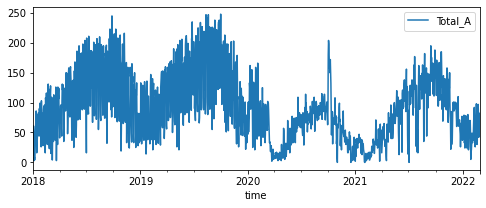

In [8]:
bike_arima_A.plot(figsize=(8,3))

<AxesSubplot:xlabel='time'>

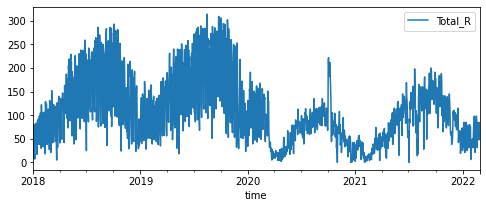

In [9]:
bike_arima_R.plot(figsize=(8,3))

---Ermittlung der Werte 'd' & 'D' vor auto_arima ---> (verkürzt die Laufzeit von auto_arima)

In [10]:
pm.arima.ndiffs(bike_arima_A, alpha=0.05, test='adf', max_d=3)#---- 'd' von Ausleihen

0

In [11]:
pm.arima.ndiffs(bike_arima_R, alpha=0.05, test='adf', max_d=3)#---- 'd' von Rückgaben

0

In [12]:
pm.arima.nsdiffs(bike_arima_A, m=7, max_D=3, test='ocsb')#---- 'D' von Ausleihen

0

In [13]:
pm.arima.nsdiffs(bike_arima_R, m=7, max_D=3, test='ocsb')#---- 'D' von Rückgaben

0

---Einbindung der Wetterdaten und zusammenfügen mit den Bikedaten 

In [14]:
weather = pd.read_csv(r'C:\Users\emres\OneDrive\BA\Data\weather.csv')

In [15]:
weather['time'] = pd.to_datetime(weather['time']).dt.strftime('%Y-%m-%d')
weather.time = pd.to_datetime(weather.time)
weather = weather.set_index('time')
weather

avg_temp_C°  precipitation_mm  windspeed_km/h
time                                                     
2017-01-01          7.9               0.0             9.8
2017-01-02          4.9               7.4            20.3
2017-01-03          5.8              10.9            26.9
2017-01-04          7.1               0.0            19.5
2017-01-05         -0.1               0.0            22.0
...                 ...               ...             ...
2022-07-04         26.2               NaN            13.8
2022-07-05         22.5               NaN            14.0
2022-07-06         24.2               NaN            14.4
2022-07-07         24.7               NaN            12.4
2022-07-08         25.8               NaN            13.8

[2015 rows x 3 columns]

In [16]:
bike_arima_AW = pd.merge(bike_arima_A, weather, on='time', how='left')
bike_arima_RW = pd.merge(bike_arima_R, weather, on='time', how='left')

In [17]:
bike_arima_AW

Total_A  avg_temp_C°  precipitation_mm  windspeed_km/h
time                                                              
2018-01-01       13         -8.6               0.0             9.6
2018-01-02       61         -6.0               0.0            19.9
2018-01-03       51         -4.0               0.0            13.0
2018-01-04        3         -2.9              18.0            10.5
2018-01-05        9         -8.1               0.0             9.1
...             ...          ...               ...             ...
2022-02-24       82          1.1               0.2            11.5
2022-02-25       42          1.7              11.2            14.8
2022-02-26       46         -0.1               0.0            12.0
2022-02-27       46          3.5               0.7            18.9
2022-02-28       82          1.3               0.0             8.9

[1520 rows x 4 columns]

---Korrelation zwischen den Variablen 

In [18]:
import seaborn as sb

In [144]:
corr_A = bike_arima_AW.corr(method='pearson')
corr_R = bike_arima_RW.corr(method='pearson')

<AxesSubplot:>

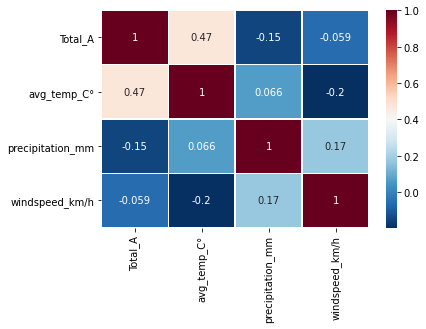

In [145]:
sb.heatmap(corr_A, 
            xticklabels=corr_A.columns,
            yticklabels=corr_A.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

<AxesSubplot:>

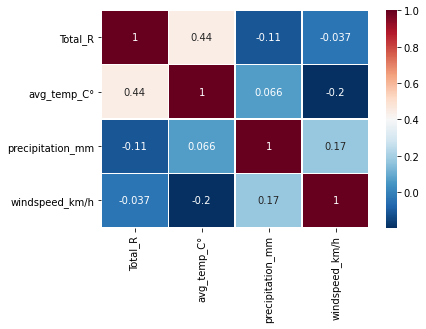

In [146]:
sb.heatmap(corr_R, 
            xticklabels=corr_R.columns,
            yticklabels=corr_R.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

---Durchführung von auto_arima zur Ermittlung des ARIMA-Modells

In [23]:
### ARIMA-Modell für die Ausleihen
model_A = pm.auto_arima(bike_arima_AW['Total_A'], max_p=3, d=0, max_q=3, max_P=3, D=0, max_Q=3, m=7,
                    seasonal=True, trace=False, error_action='ignore', suppress_warnings=True, stepwise=True)
print(model_A.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1520
Model:             SARIMAX(1, 0, 0)x(3, 0, [1], 7)   Log Likelihood               -7248.366
Date:                             Wed, 27 Jul 2022   AIC                          14510.732
Time:                                     12:09:24   BIC                          14548.017
Sample:                                          0   HQIC                         14524.613
                                            - 1520                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.5269      0.666      3.793      0.000       1.221       3.833
ar.L1          0.4667      

In [24]:
### ARIMA-Modell für die Rückgaben
model_R = pm.auto_arima(bike_arima_RW['Total_R'], max_p=3, d=0, max_q=3, max_P=3, D=0, max_Q=3, m=7,
                        seasonal=True, trace=False, error_action='ignore', suppress_warnings=True, stepwise=True)
print(model_R.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1520
Model:             SARIMAX(3, 0, 0)x(1, 0, [1], 7)   Log Likelihood               -7424.145
Date:                             Wed, 27 Jul 2022   AIC                          14862.289
Time:                                     12:14:04   BIC                          14899.575
Sample:                                          0   HQIC                         14876.170
                                            - 1520                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.8005      0.327      2.445      0.014       0.159       1.442
ar.L1          0.4187      

---Unterteilung in train & test Daten

In [25]:
train_arima_A = bike_arima_AW[:1461]
test_arima_A = bike_arima_AW[-59:]

train_arima_R = bike_arima_RW[:1461]
test_arima_R = bike_arima_RW[-59:]

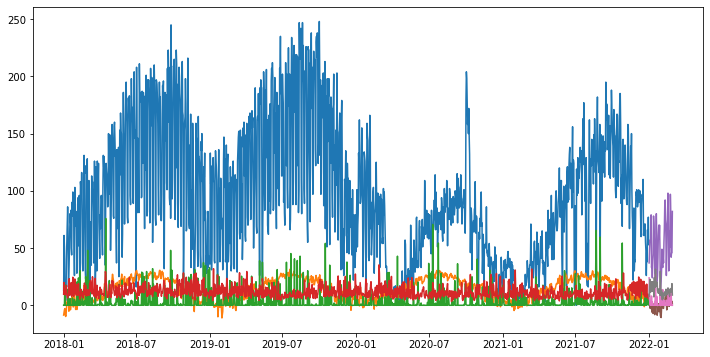

In [26]:
plt.figure(figsize=(12,6))
plt.plot(train_arima_A)
plt.plot(test_arima_A)

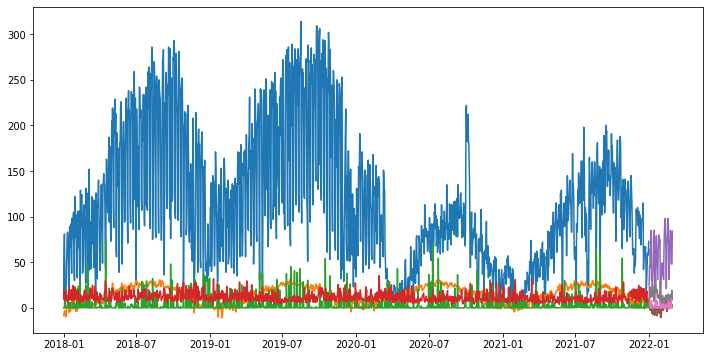

In [27]:
plt.figure(figsize=(12,6))
plt.plot(train_arima_R)
plt.plot(test_arima_R)

---Durchführung des SARIMAX-Modells mit den exog Variablen

--Ausleihen

In [28]:
model_train_A_ex1 = SARIMAX(train_arima_A['Total_A'], exog=train_arima_A['avg_temp_C°'], order=(1, 0, 0), seasonal_order=(3, 0, 1, 7))
model_result_train_A_ex1 = model_train_A_ex1.fit()
model_result_train_A_ex1.summary()

c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                             Total_A   No. Observations:                 1461
Model:             SARIMAX(1, 0, 0)x(3, 0, [1], 7)   Log Likelihood               -6920.069
Date:                             Wed, 27 Jul 2022   AIC                          13854.139
Time:                                     12:14:20   BIC                          13891.147
Sample:                                 01-01-2018   HQIC                         13867.944
                                      - 12-31-2021                                         
Covariance Type:                               opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
avg_temp_C°     2.6082      0.197     13.261      0.000       2.223       2.994
ar.L1           0.4438      0.019     23.117      0.000       0.406       0.481
ar.S.L7         1.0859      0.035     31.081      0.000       1.017       1.154
ar.S.L14       -0.1003      0.033     -3.048      0.002      -0.165      -0.036
ar.S.L21        0.0055      0.027      0.202      0.840      -0.048       0.059
ma.S.L7        -0.8025      0.028    -28.478      0.000      -0.858      -0.747
sigma2        754.6019     22.141     34.082      0.000     711.206     797.997
===================================================================================
Ljung-Box (Q):                      172.46   Jarque-Bera (JB):               291.76
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                            -0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
model_train_A_ex2 = SARIMAX(train_arima_A['Total_A'], exog=train_arima_A['precipitation_mm'], order=(1, 0, 0), seasonal_order=(3, 0, 1, 7))
model_result_train_A_ex2 = model_train_A_ex2.fit()
model_result_train_A_ex2.summary()

c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                             Total_A   No. Observations:                 1461
Model:             SARIMAX(1, 0, 0)x(3, 0, [1], 7)   Log Likelihood               -6821.540
Date:                             Wed, 27 Jul 2022   AIC                          13657.080
Time:                                     12:14:43   BIC                          13694.088
Sample:                                 01-01-2018   HQIC                         13670.885
                                      - 12-31-2021                                         
Covariance Type:                               opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
precipitation_mm    -1.3568      0.047    -28.844      0.000      -1.449      -1.265
ar.L1                0.5377      0.019     28.080      0.000       0.500       0.575
ar.S.L7              0.9579      0.044     21.910      0.000       0.872       1.044
ar.S.L14            -0.0185      0.034     -0.541      0.589      -0.085       0.048
ar.S.L21             0.0479      0.031      1.537      0.124      -0.013       0.109
ma.S.L7             -0.6683      0.039    -17.033      0.000      -0.745      -0.591
sigma2             657.9383     19.315     34.064      0.000     620.082     695.794
===================================================================================
Ljung-Box (Q):                      257.18   Jarque-Bera (JB):               170.96
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
model_train_A_ex3 = SARIMAX(train_arima_A['Total_A'], exog=train_arima_A['windspeed_km/h'], order=(1, 0, 0), seasonal_order=(3, 0, 1, 7))
model_result_train_A_ex3 = model_train_A_ex3.fit()
model_result_train_A_ex3.summary()

c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                             Total_A   No. Observations:                 1461
Model:             SARIMAX(1, 0, 0)x(3, 0, [1], 7)   Log Likelihood               -6986.161
Date:                             Wed, 27 Jul 2022   AIC                          13986.322
Time:                                     12:15:02   BIC                          14023.330
Sample:                                 01-01-2018   HQIC                         14000.127
                                      - 12-31-2021                                         
Covariance Type:                               opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
windspeed_km/h    -0.6242      0.141     -4.422      0.000      -0.901      -0.348
ar.L1              0.4871      0.020     24.096      0.000       0.447       0.527
ar.S.L7            1.0246      0.040     25.591      0.000       0.946       1.103
ar.S.L14          -0.0446      0.033     -1.362      0.173      -0.109       0.020
ar.S.L21           0.0100      0.029      0.345      0.730      -0.047       0.067
ma.S.L7           -0.7258      0.035    -20.566      0.000      -0.795      -0.657
sigma2           824.9362     24.153     34.155      0.000     777.598     872.274
===================================================================================
Ljung-Box (Q):                      265.29   Jarque-Bera (JB):               312.26
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                            -0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

--Rückgaben

In [31]:
model_train_R_ex1 = SARIMAX(train_arima_R['Total_R'], exog=train_arima_R['avg_temp_C°'], order=(3, 0, 0), seasonal_order=(1, 0, 1, 7))
model_result_train_R_ex1 = model_train_R_ex1.fit()
model_result_train_R_ex1.summary()

c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                             Total_R   No. Observations:                 1461
Model:             SARIMAX(3, 0, 0)x(1, 0, [1], 7)   Log Likelihood               -7109.512
Date:                             Wed, 27 Jul 2022   AIC                          14233.024
Time:                                     12:15:07   BIC                          14270.032
Sample:                                 01-01-2018   HQIC                         14246.829
                                      - 12-31-2021                                         
Covariance Type:                               opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
avg_temp_C°     2.6315      0.246     10.687      0.000       2.149       3.114
ar.L1           0.3939      0.019     20.688      0.000       0.357       0.431
ar.L2           0.0893      0.026      3.468      0.001       0.039       0.140
ar.L3           0.1366      0.023      6.002      0.000       0.092       0.181
ar.S.L7         0.9870      0.003    294.170      0.000       0.980       0.994
ma.S.L7        -0.7615      0.017    -44.984      0.000      -0.795      -0.728
sigma2        978.3808     25.651     38.143      0.000     928.107    1028.655
===================================================================================
Ljung-Box (Q):                       78.94   Jarque-Bera (JB):               786.95
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                            -0.75
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
model_train_R_ex2 = SARIMAX(train_arima_R['Total_R'], exog=train_arima_R['precipitation_mm'], order=(3, 0, 0), seasonal_order=(1, 0, 1, 7))
model_result_train_R_ex2 = model_train_R_ex2.fit()
model_result_train_R_ex2.summary()

c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                             Total_R   No. Observations:                 1461
Model:             SARIMAX(3, 0, 0)x(1, 0, [1], 7)   Log Likelihood               -7019.989
Date:                             Wed, 27 Jul 2022   AIC                          14053.979
Time:                                     12:15:12   BIC                          14090.987
Sample:                                 01-01-2018   HQIC                         14067.784
                                      - 12-31-2021                                         
Covariance Type:                               opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
precipitation_mm    -1.3997      0.057    -24.744      0.000      -1.511      -1.289
ar.L1                0.4590      0.020     23.041      0.000       0.420       0.498
ar.L2                0.1035      0.026      3.982      0.000       0.053       0.155
ar.L3                0.1426      0.023      6.189      0.000       0.097       0.188
ar.S.L7              0.9866      0.003    296.271      0.000       0.980       0.993
ma.S.L7             -0.7263      0.017    -42.948      0.000      -0.759      -0.693
sigma2             864.7594     22.412     38.585      0.000     820.833     908.686
===================================================================================
Ljung-Box (Q):                       84.82   Jarque-Bera (JB):               534.01
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.47   Skew:                            -0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
model_train_R_ex3 = SARIMAX(train_arima_R['Total_R'], exog=train_arima_R['windspeed_km/h'], order=(3, 0, 0), seasonal_order=(1, 0, 1, 7))
model_result_train_R_ex3 = model_train_R_ex3.fit()
model_result_train_R_ex3.summary()

c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                             Total_R   No. Observations:                 1461
Model:             SARIMAX(3, 0, 0)x(1, 0, [1], 7)   Log Likelihood               -7149.416
Date:                             Wed, 27 Jul 2022   AIC                          14312.832
Time:                                     12:15:19   BIC                          14349.840
Sample:                                 01-01-2018   HQIC                         14326.637
                                      - 12-31-2021                                         
Covariance Type:                               opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
windspeed_km/h    -0.8272      0.164     -5.036      0.000      -1.149      -0.505
ar.L1              0.4244      0.019     22.491      0.000       0.387       0.461
ar.L2              0.1157      0.025      4.558      0.000       0.066       0.165
ar.L3              0.1452      0.024      6.165      0.000       0.099       0.191
ar.S.L7            0.9874      0.003    302.925      0.000       0.981       0.994
ma.S.L7           -0.7440      0.017    -42.777      0.000      -0.778      -0.710
sigma2          1030.9328     26.610     38.743      0.000     978.779    1083.087
===================================================================================
Ljung-Box (Q):                       90.37   Jarque-Bera (JB):               848.92
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.46   Skew:                            -0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

---Abschnitt der Prognose für die Zukunft---

In [34]:
from pandas.tseries.offsets import DateOffset

In [35]:
bike_arima_AW_new = bike_arima_AW.copy()
bike_arima_RW_new = bike_arima_RW.copy()

In [36]:
future_dates_AW = [bike_arima_AW_new.index[-60] + DateOffset(days = x) for x in range(0,88)]
future_dates_RW = [bike_arima_RW_new.index[-60] + DateOffset(days = x) for x in range(0,88)]
future_dates_RW

[Timestamp('2021-12-31 00:00:00'),
 Timestamp('2022-01-01 00:00:00'),
 Timestamp('2022-01-02 00:00:00'),
 Timestamp('2022-01-03 00:00:00'),
 Timestamp('2022-01-04 00:00:00'),
 Timestamp('2022-01-05 00:00:00'),
 Timestamp('2022-01-06 00:00:00'),
 Timestamp('2022-01-07 00:00:00'),
 Timestamp('2022-01-08 00:00:00'),
 Timestamp('2022-01-09 00:00:00'),
 Timestamp('2022-01-10 00:00:00'),
 Timestamp('2022-01-11 00:00:00'),
 Timestamp('2022-01-12 00:00:00'),
 Timestamp('2022-01-13 00:00:00'),
 Timestamp('2022-01-14 00:00:00'),
 Timestamp('2022-01-15 00:00:00'),
 Timestamp('2022-01-16 00:00:00'),
 Timestamp('2022-01-17 00:00:00'),
 Timestamp('2022-01-18 00:00:00'),
 Timestamp('2022-01-19 00:00:00'),
 Timestamp('2022-01-20 00:00:00'),
 Timestamp('2022-01-21 00:00:00'),
 Timestamp('2022-01-22 00:00:00'),
 Timestamp('2022-01-23 00:00:00'),
 Timestamp('2022-01-24 00:00:00'),
 Timestamp('2022-01-25 00:00:00'),
 Timestamp('2022-01-26 00:00:00'),
 Timestamp('2022-01-27 00:00:00'),
 Timestamp('2022-01-

In [37]:
future_date_df_AW = pd.DataFrame(index = future_dates_AW[1:], columns = bike_arima_AW_new.columns)
future_date_df_RW = pd.DataFrame(index = future_dates_RW[1:], columns = bike_arima_RW_new.columns)
future_date_df_RW.tail()

Total_R avg_temp_C° precipitation_mm windspeed_km/h
2022-03-24     NaN         NaN              NaN            NaN
2022-03-25     NaN         NaN              NaN            NaN
2022-03-26     NaN         NaN              NaN            NaN
2022-03-27     NaN         NaN              NaN            NaN
2022-03-28     NaN         NaN              NaN            NaN

In [38]:
bike_arima_AW_new = pd.concat([bike_arima_AW_new, future_date_df_AW[-87:]])
bike_arima_RW_new = pd.concat([bike_arima_RW_new, future_date_df_RW[-87:]])

In [39]:
bike_arima_AW_new = bike_arima_AW_new[~bike_arima_AW_new.index.duplicated(keep='first')]
bike_arima_AW_new.index.name = 'time'
bike_arima_RW_new = bike_arima_RW_new[~bike_arima_RW_new.index.duplicated(keep='first')]
bike_arima_RW_new.index.name = 'time'

In [40]:
cols_to_use_AW = bike_arima_AW_new.columns.difference(weather.columns)
cols_to_use_RW = bike_arima_RW_new.columns.difference(weather.columns)

In [41]:
bike_arima_AW_new = pd.merge(bike_arima_AW_new[cols_to_use_AW], weather, on='time')
bike_arima_RW_new = pd.merge(bike_arima_RW_new[cols_to_use_RW], weather, on='time')

In [42]:
bike_arima_AW_new
bike_arima_RW_new

Total_R  avg_temp_C°  precipitation_mm  windspeed_km/h
time                                                             
2018-01-01      12         -8.6               0.0             9.6
2018-01-02      60         -6.0               0.0            19.9
2018-01-03      81         -4.0               0.0            13.0
2018-01-04      11         -2.9              18.0            10.5
2018-01-05      17         -8.1               0.0             9.1
...            ...          ...               ...             ...
2022-03-24     NaN          6.4              15.6            27.1
2022-03-25     NaN         10.1               1.0            12.9
2022-03-26     NaN          9.6               1.8            16.6
2022-03-27     NaN          5.1               0.2            11.3
2022-03-28     NaN         -1.0               1.7             9.6

[1548 rows x 4 columns]

In [43]:
history_arima_A = bike_arima_AW_new[:1461]
future_arima_A = bike_arima_AW_new[-87:]

history_arima_R = bike_arima_RW_new[:1461]
future_arima_R = bike_arima_RW_new[-87:]

In [44]:
bike_arima_AW_new['forecast_avg_temp_C°'] = model_result_train_A_ex1.predict(start=len(history_arima_A), end=len(bike_arima_AW_new)-1, exog=future_arima_A['avg_temp_C°'])
bike_arima_AW_new['forecast_precipitation_mm'] = model_result_train_A_ex2.predict(start=len(history_arima_A), end=len(bike_arima_AW_new)-1, exog=future_arima_A['precipitation_mm'])
bike_arima_AW_new['forecast_windspeed_km/h'] = model_result_train_A_ex3.predict(start=len(history_arima_A), end=len(bike_arima_AW_new)-1, exog=future_arima_A['windspeed_km/h'])

bike_arima_RW_new['forecast_avg_temp_C°'] = model_result_train_R_ex1.predict(start=len(history_arima_R), end=len(bike_arima_RW_new)-1, exog=future_arima_R['avg_temp_C°'])
bike_arima_RW_new['forecast_precipitation_mm'] = model_result_train_R_ex2.predict(start=len(history_arima_R), end=len(bike_arima_RW_new)-1, exog=future_arima_R['precipitation_mm'])
bike_arima_RW_new['forecast_windspeed_km/h'] = model_result_train_R_ex3.predict(start=len(history_arima_R), end=len(bike_arima_RW_new)-1, exog=future_arima_R['windspeed_km/h'])

In [45]:
bike_arima_AW_new.drop('Total_A', axis=1).tail(28)

avg_temp_C°  precipitation_mm  windspeed_km/h  \
time                                                        
2022-03-01          4.4               0.2            10.7   
2022-03-02          7.9               0.0             9.4   
2022-03-03          4.7               1.9            10.3   
2022-03-04         -0.4               0.0            11.8   
2022-03-05          4.1               0.0             7.7   
2022-03-06         12.4               1.9            15.1   
2022-03-07         17.8               4.1            15.5   
2022-03-08          7.3               0.2             8.4   
2022-03-09          3.5              11.4            13.3   
2022-03-10          5.0               0.0             7.5   
2022-03-11          7.2               0.2             7.7   
2022-03-12          2.9              13.8             6.5   
2022-03-13         -3.1               0.0            24.1   
2022-03-14          6.8               0.0            10.2   
2022-03-15         11.9               0.5             7.0   
2022-03-16         12.9               0.7             9.1   
2022-03-17          9.5               2.2            17.8   
2022-03-18         13.2               0.2             7.4   
2022-03-19         14.0              17.9             8.2   
2022-03-20         12.2               0.2            10.5   
2022-03-21         11.8               0.9             7.7   
2022-03-22         11.5               0.0             6.2   
2022-03-23          6.8               4.1            17.9   
2022-03-24          6.4              15.6            27.1   
2022-03-25         10.1               1.0            12.9   
2022-03-26          9.6               1.8            16.6   
2022-03-27          5.1               0.2            11.3   
2022-03-28         -1.0               1.7             9.6   

            forecast_avg_temp_C°  forecast_precipitation_mm  \
time                                                          
2022-03-01             79.442582                  75.286390   
2022-03-02             87.178738                  77.154697   
2022-03-03             75.014501                  71.001330   
2022-03-04             50.479981                  64.393188   
2022-03-05             45.416621                  52.727354   
2022-03-06             77.232182                  51.997276   
2022-03-07             99.656242                  55.777013   
2022-03-08             86.341484                  74.401298   
2022-03-09             75.051381                  60.783285   
2022-03-10             75.183048                  72.717346   
2022-03-11             69.798293                  63.367505   
2022-03-12             41.947098                  33.385745   
2022-03-13             36.365894                  53.935907   
2022-03-14             70.445282                  60.621378   
2022-03-15             97.680835                  73.119531   
2022-03-16             98.923596                  74.407916   
2022-03-17             86.312053                  68.880552   
2022-03-18             84.948412                  62.622032   
2022-03-19             70.561793                  27.212415   
2022-03-20             75.836550                  53.032735   
2022-03-21             82.970663                  58.690128   
2022-03-22             95.985613                  72.933461   
2022-03-23             82.374975                  68.912025   
2022-03-24             77.624662                  49.857490   
2022-03-25             76.368767                  60.799849   
2022-03-26             58.752634                  48.453755   
2022-03-27             56.887716                  52.408328   
2022-03-28             49.075076                  56.902878   

            forecast_windspeed_km/h  
time                                 
2022-03-01                76.795470  
2022-03-02                77.692385  
2022-03-03                76.704256  
2022-03-04                65.151159  
2022-03-05                51.199332  
2022-03-06              

In [46]:
bike_arima_AW_new.drop(bike_arima_AW_new.loc[bike_arima_AW_new.index < '2021-12-01'].index, inplace=True)
bike_arima_RW_new.drop(bike_arima_RW_new.loc[bike_arima_RW_new.index < '2021-12-01'].index, inplace=True)

In [47]:
bike_arima_AW_new

Total_A  avg_temp_C°  precipitation_mm  windspeed_km/h  \
time                                                                
2021-12-01     101          4.8               0.0            12.3   
2021-12-02      96         10.4               4.4            20.5   
2021-12-03      86          5.0               0.0            18.0   
2021-12-04      89          4.6               0.0             8.5   
2021-12-05      95          4.6               0.0             8.3   
...            ...          ...               ...             ...   
2022-03-24     NaN          6.4              15.6            27.1   
2022-03-25     NaN         10.1               1.0            12.9   
2022-03-26     NaN          9.6               1.8            16.6   
2022-03-27     NaN          5.1               0.2            11.3   
2022-03-28     NaN         -1.0               1.7             9.6   

            forecast_avg_temp_C°  forecast_precipitation_mm  \
time                                                          
2021-12-01                   NaN                        NaN   
2021-12-02                   NaN                        NaN   
2021-12-03                   NaN                        NaN   
2021-12-04                   NaN                        NaN   
2021-12-05                   NaN                        NaN   
...                          ...                        ...   
2022-03-24             77.624662                  49.857490   
2022-03-25             76.368767                  60.799849   
2022-03-26             58.752634                  48.453755   
2022-03-27             56.887716                  52.408328   
2022-03-28             49.075076                  56.902878   

            forecast_windspeed_km/h  
time                                 
2021-12-01                      NaN  
2021-12-02                      NaN  
2021-12-03                      NaN  
2021-12-04                      NaN  
2021-12-05                      NaN  
...                             ...  
2022-03-24                63.705157  
2022-03-25                62.272814  
2022-03-26                43.951285  
2022-03-27                57.079137  
2022-03-28                62.024750  

[118 rows x 7 columns]

--Grafiken der Prognose für die Ausleihen & Rückgaben mit den exog Variablen

<AxesSubplot:title={'center':'Vorhersage der Rückgaben'}, xlabel='time'>

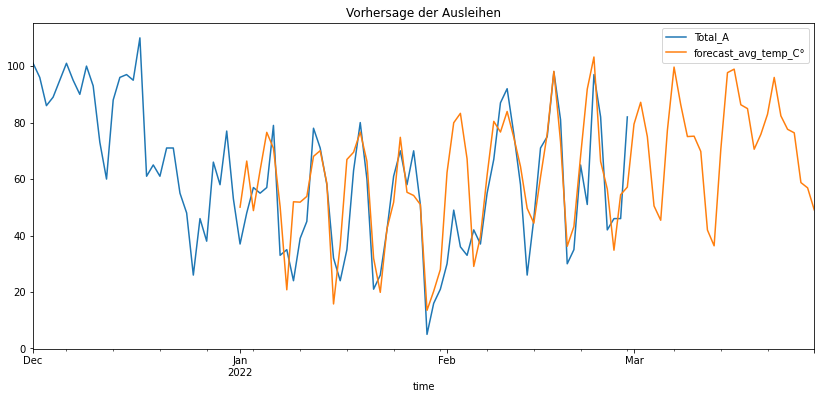

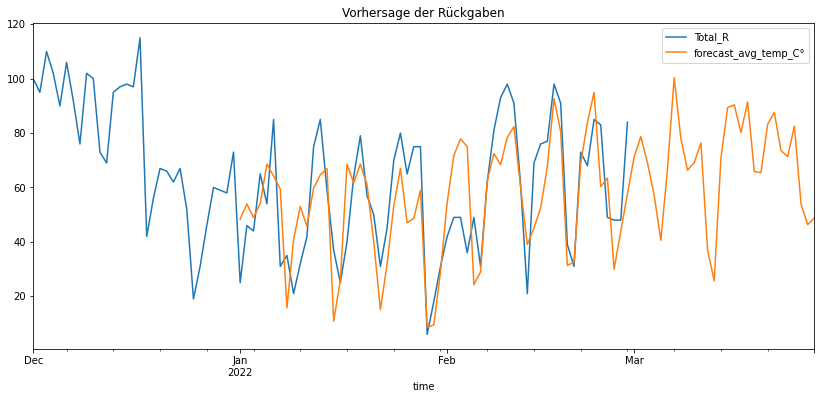

In [48]:
bike_arima_AW_new[['Total_A', 'forecast_avg_temp_C°']].plot(figsize=(14,6), title='Vorhersage der Ausleihen')
bike_arima_RW_new[['Total_R', 'forecast_avg_temp_C°']].plot(figsize=(14,6), title='Vorhersage der Rückgaben')

<AxesSubplot:title={'center':'Vorhersage der Rückgaben'}, xlabel='time'>

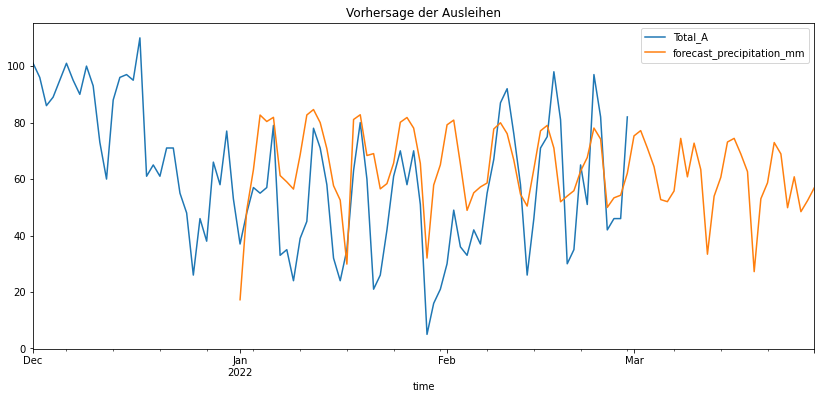

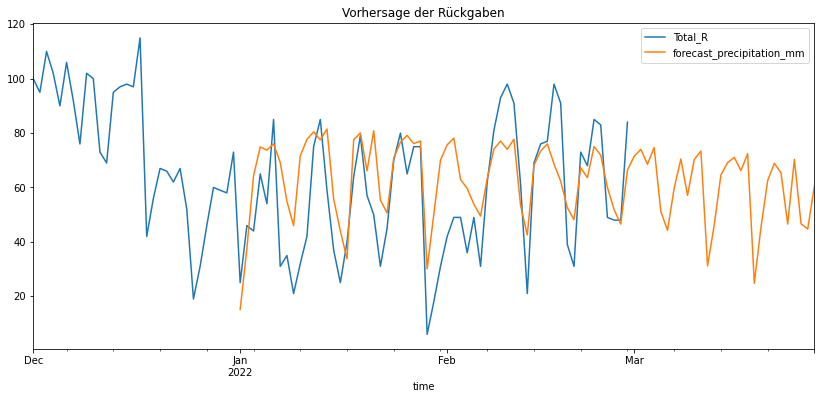

In [49]:
bike_arima_AW_new[['Total_A', 'forecast_precipitation_mm']].plot(figsize=(14,6), title='Vorhersage der Ausleihen')
bike_arima_RW_new[['Total_R', 'forecast_precipitation_mm']].plot(figsize=(14,6), title='Vorhersage der Rückgaben')

<AxesSubplot:title={'center':'Vorhersage der Rückgaben'}, xlabel='time'>

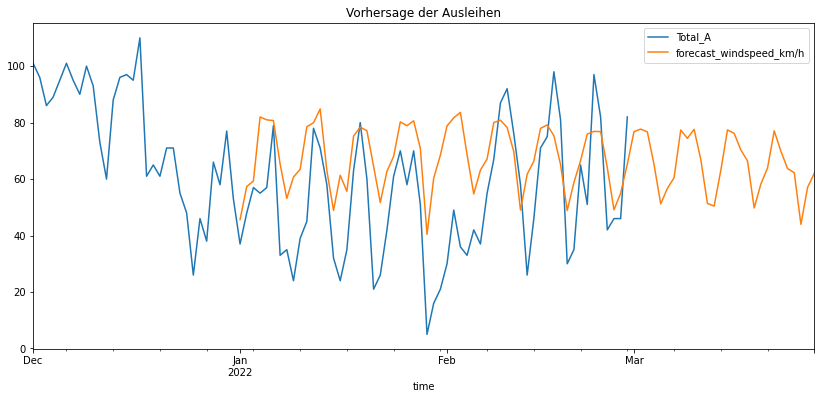

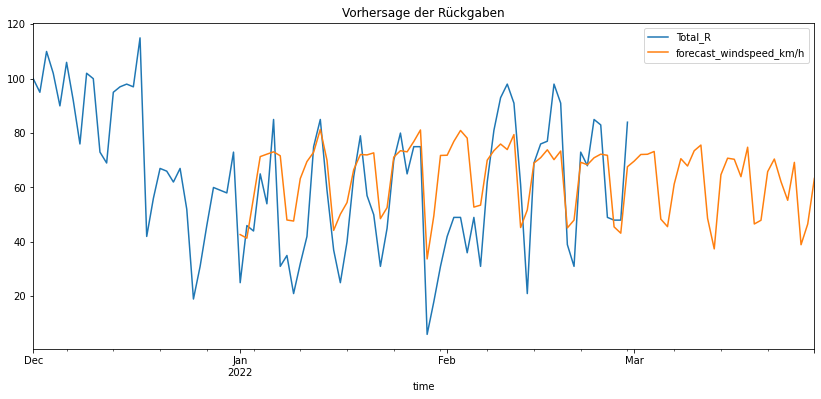

In [50]:
bike_arima_AW_new[['Total_A', 'forecast_windspeed_km/h']].plot(figsize=(14,6), title='Vorhersage der Ausleihen')
bike_arima_RW_new[['Total_R', 'forecast_windspeed_km/h']].plot(figsize=(14,6), title='Vorhersage der Rückgaben')

---Prognose über die historischen Daten

In [51]:
train_prediction_A_ex1 = model_result_train_A_ex1.predict(start = len(train_arima_A), end = len(bike_arima_AW)-1, exog=test_arima_A['avg_temp_C°']).rename('Test_ARIMA_Predictions_A_ex1')###---predict von Ende train_arima_A bis Ende test_arima_A = testdaten
train_prediction_R_ex1 = model_result_train_R_ex1.predict(start = len(train_arima_R), end = len(bike_arima_RW)-1, exog=test_arima_R['avg_temp_C°']).rename('Test_ARIMA_Predictions_R_ex1')###---predict von Ende train_arima_R bis Ende test_arima_R = testdaten

train_prediction_A_ex2 = model_result_train_A_ex2.predict(start = len(train_arima_A), end = len(bike_arima_AW)-1, exog=test_arima_A['precipitation_mm']).rename('Test_ARIMA_Predictions_A_ex2') 
train_prediction_R_ex2 = model_result_train_R_ex2.predict(start = len(train_arima_R), end = len(bike_arima_RW)-1, exog=test_arima_R['precipitation_mm']).rename('Test_ARIMA_Predictions_R_ex2') 

train_prediction_A_ex3 = model_result_train_A_ex3.predict(start = len(train_arima_A), end = len(bike_arima_AW)-1, exog=test_arima_A['windspeed_km/h']).rename('Test_ARIMA_Predictions_A_ex3') 
train_prediction_R_ex3 = model_result_train_R_ex3.predict(start = len(train_arima_R), end = len(bike_arima_RW)-1, exog=test_arima_R['windspeed_km/h']).rename('Test_ARIMA_Predictions_R_ex3')

---Grafiken ohne Zukunftswerte

--Ausleihen

<AxesSubplot:xlabel='time'>

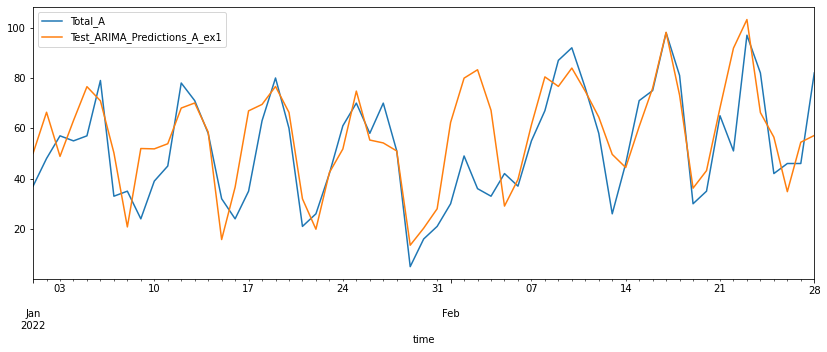

In [52]:
test_arima_A['Total_A'].plot(figsize=(14,5), legend=True)
train_prediction_A_ex1.plot(legend=True)

<AxesSubplot:xlabel='time'>

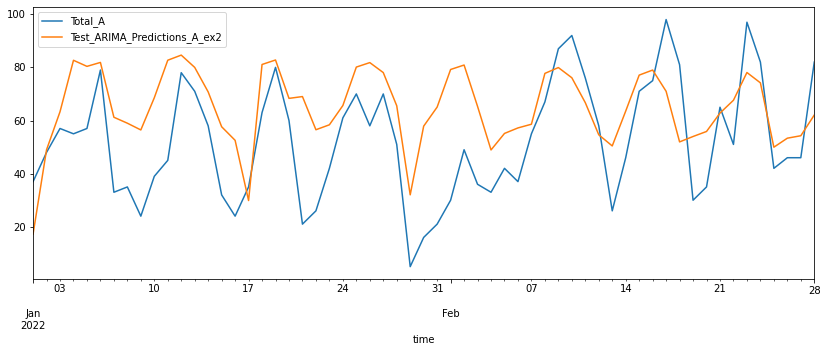

In [53]:
test_arima_A['Total_A'].plot(figsize=(14,5), legend=True)
train_prediction_A_ex2.plot(legend=True)

<AxesSubplot:xlabel='time'>

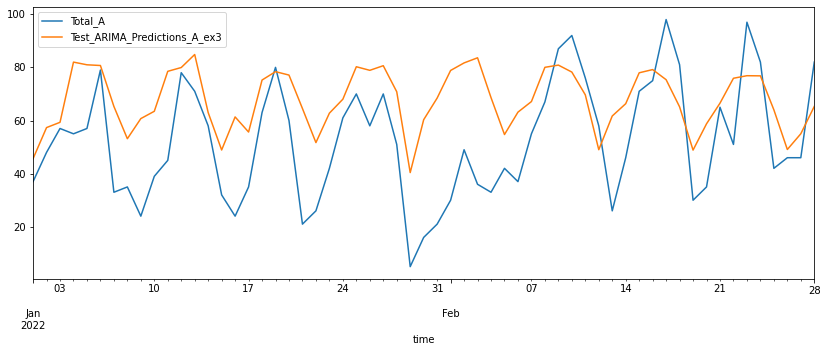

In [54]:
test_arima_A['Total_A'].plot(figsize=(14,5), legend=True)
train_prediction_A_ex3.plot(legend=True)

--Rückgaben

<AxesSubplot:xlabel='time'>

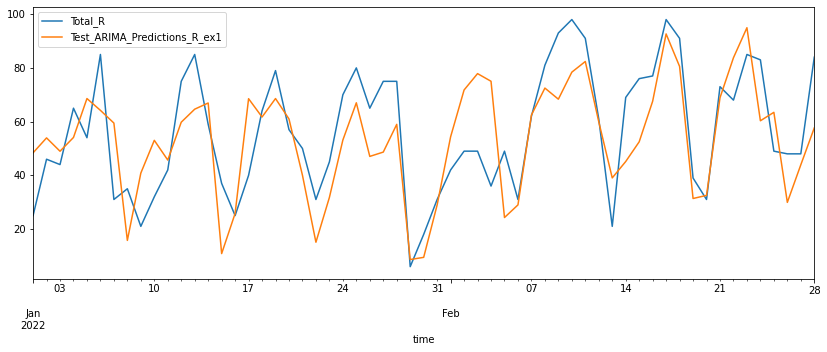

In [55]:
test_arima_R['Total_R'].plot(figsize=(14,5), legend=True)
train_prediction_R_ex1.plot(legend=True)

<AxesSubplot:xlabel='time'>

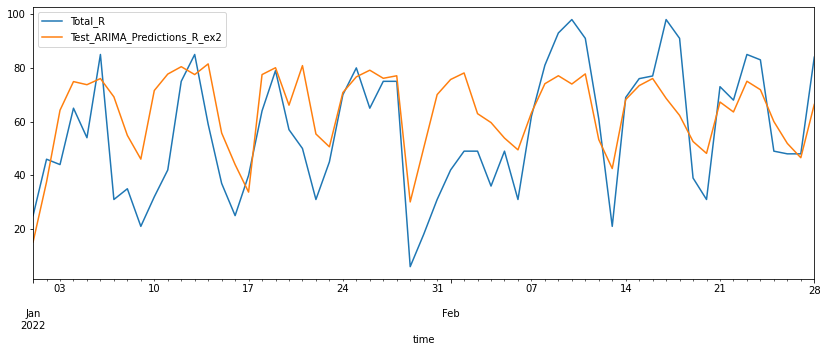

In [56]:
test_arima_R['Total_R'].plot(figsize=(14,5), legend=True)
train_prediction_R_ex2.plot(legend=True)

<AxesSubplot:xlabel='time'>

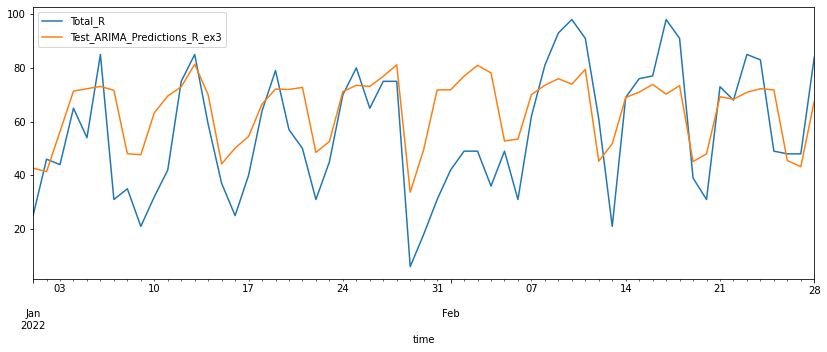

In [57]:
test_arima_R['Total_R'].plot(figsize=(14,5), legend=True)
train_prediction_R_ex3.plot(legend=True)

---Fehlermaß ermitteln

In [58]:
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_error

--Ausleihen

In [59]:
test_arima_rmse_error_A_ex1 = rmse(test_arima_A['Total_A'], train_prediction_A_ex1)
test_arima_mse_error_A_ex1 = test_arima_rmse_error_A_ex1**2
test_arima_mape_error_A_ex1 = mean_absolute_error(test_arima_A['Total_A'], train_prediction_A_ex1)
test_mean_value_A_ex1 = bike_arima_AW['Total_A'].mean()

print(f'RMSE Error: {test_arima_rmse_error_A_ex1}\nMSE Error: {test_arima_mse_error_A_ex1}\nMAPE Error: {test_arima_mape_error_A_ex1}\nMean: {test_mean_value_A_ex1}')

RMSE Error: 15.810461435461319
MSE Error: 249.9706908022096
MAPE Error: 11.942140547665348
Mean: 94.10526315789474


In [60]:
test_arima_rmse_error_A_ex2 = rmse(test_arima_A['Total_A'], train_prediction_A_ex2)
test_arima_mse_error_A_ex2 = test_arima_rmse_error_A_ex2**2
test_arima_mape_error_A_ex2 = mean_absolute_error(test_arima_A['Total_A'], train_prediction_A_ex2)
test_mean_value_A_ex2 = bike_arima_AW['Total_A'].mean()

print(f'RMSE Error: {test_arima_rmse_error_A_ex2}\nMSE Error: {test_arima_mse_error_A_ex2}\nMAPE Error: {test_arima_mape_error_A_ex2}\nMean: {test_mean_value_A_ex2}')

RMSE Error: 21.803630444898364
MSE Error: 475.3983005776988
MAPE Error: 18.144950363352248
Mean: 94.10526315789474


In [61]:
test_arima_rmse_error_A_ex3 = rmse(test_arima_A['Total_A'], train_prediction_A_ex3)
test_arima_mse_error_A_ex3 = test_arima_rmse_error_A_ex3**2
test_arima_mape_error_A_ex3 = mean_absolute_error(test_arima_A['Total_A'], train_prediction_A_ex3)
test_mean_value_A_ex3 = bike_arima_AW['Total_A'].mean()

print(f'RMSE Error: {test_arima_rmse_error_A_ex3}\nMSE Error: {test_arima_mse_error_A_ex3}\nMAPE Error: {test_arima_mape_error_A_ex3}\nMean: {test_mean_value_A_ex3}')

RMSE Error: 23.320512079574677
MSE Error: 543.8462836535884
MAPE Error: 19.413845430853897
Mean: 94.10526315789474


In [62]:
rmse_arima_A = pd.DataFrame({"Wetterart" : ["Durchschnittstemperatur", "Niederschlagsmenge", "Windgeschwindigkeit"], "RMSE der Ausleihen in ARIMA" : (test_arima_rmse_error_A_ex1, test_arima_rmse_error_A_ex2, test_arima_rmse_error_A_ex3)})
rmse_arima_A

Wetterart  RMSE der Ausleihen in ARIMA
0  Durchschnittstemperatur                    15.810461
1       Niederschlagsmenge                    21.803630
2      Windgeschwindigkeit                    23.320512

--Rückgaben

In [63]:
test_arima_rmse_error_R_ex1 = rmse(test_arima_R['Total_R'], train_prediction_R_ex1)
test_arima_mse_error_R_ex1 = test_arima_rmse_error_R_ex1**2
test_arima_mape_error_R_ex1 = mean_absolute_error(test_arima_R['Total_R'], train_prediction_R_ex1)
test_mean_value_R_ex1 = bike_arima_RW['Total_R'].mean()

print(f'RMSE Error: {test_arima_rmse_error_R_ex1}\nMSE Error: {test_arima_mse_error_R_ex1}\nMAPE Error: {test_arima_mape_error_R_ex1}\nMean: {test_mean_value_R_ex1}')

RMSE Error: 16.847681806520093
MSE Error: 283.84438225374817
MAPE Error: 14.253394901269994
Mean: 111.58486842105263


In [64]:
test_arima_rmse_error_R_ex2 = rmse(test_arima_R['Total_R'], train_prediction_R_ex2)
test_arima_mse_error_R_ex2 = test_arima_rmse_error_R_ex2**2
test_arima_mape_error_R_ex2 = mean_absolute_error(test_arima_R['Total_R'], train_prediction_R_ex2)
test_mean_value_R_ex2 = bike_arima_RW['Total_R'].mean()

print(f'RMSE Error: {test_arima_rmse_error_R_ex2}\nMSE Error: {test_arima_mse_error_R_ex2}\nMAPE Error: {test_arima_mape_error_R_ex2}\nMean: {test_mean_value_R_ex2}')

RMSE Error: 18.680968376525975
MSE Error: 348.97857948476354
MAPE Error: 15.067080268397847
Mean: 111.58486842105263


In [65]:
test_arima_rmse_error_R_ex3 = rmse(test_arima_R['Total_R'], train_prediction_R_ex3)
test_arima_mse_error_R_ex3 = test_arima_rmse_error_R_ex3**2
test_arima_mape_error_R_ex3 = mean_absolute_error(test_arima_R['Total_R'], train_prediction_R_ex3)
test_mean_value_R_ex3 = bike_arima_RW['Total_R'].mean()

print(f'RMSE Error: {test_arima_rmse_error_R_ex3}\nMSE Error: {test_arima_mse_error_R_ex3}\nMAPE Error: {test_arima_mape_error_R_ex3}\nMean: {test_mean_value_R_ex3}')

RMSE Error: 18.83776630342581
MSE Error: 354.8614393024849
MAPE Error: 15.16764494696019
Mean: 111.58486842105263


In [66]:
rmse_arima_R = pd.DataFrame({"Wetterart" : ["Durchschnittstemperatur", "Niederschlagsmenge", "Windgeschwindigkeit"], "RMSE der Rückgaben in ARIMA" : (test_arima_rmse_error_R_ex1, test_arima_rmse_error_R_ex2, test_arima_rmse_error_R_ex3)})
rmse_arima_R

Wetterart  RMSE der Rückgaben in ARIMA
0  Durchschnittstemperatur                    16.847682
1       Niederschlagsmenge                    18.680968
2      Windgeschwindigkeit                    18.837766

In [67]:
test_arima_A
#test_arima_R

Total_A  avg_temp_C°  precipitation_mm  windspeed_km/h
time                                                              
2022-01-01       37          9.7              24.0             7.8
2022-01-02       48          9.1               5.2            15.7
2022-01-03       57         -1.9               2.5            22.7
2022-01-04       55         -2.8               0.0            11.1
2022-01-05       57          3.0               3.3            13.3
2022-01-06       79          1.5               0.0            14.7
2022-01-07       33         -1.2               8.1            20.5
2022-01-08       35         -6.0               0.0            12.0
2022-01-09       24          1.5               3.2            17.6
2022-01-10       39         -2.1               0.0            20.6
2022-01-11       45         -7.2               0.0            18.1
2022-01-12       78         -1.2               0.0            16.1
2022-01-13       71          1.1               0.0             7.3
2022-01-14       58          1.3               0.0            24.2
2022-01-15       32         -8.2               0.0            18.2
2022-01-16       24         -4.4               5.1            15.6
2022-01-17       35          3.8              27.1            31.6
2022-01-18       63         -1.0               0.0            21.7
2022-01-19       80          2.3               0.0            16.8
2022-01-20       60         -0.1               7.8            18.1
2022-01-21       21         -8.7               0.0            20.2
2022-01-22       26         -6.5               0.0            12.6
2022-01-23       42         -2.0               0.1            12.1
2022-01-24       61         -1.8               0.1            10.5
2022-01-25       70          1.3               0.0            12.2
2022-01-26       58         -5.6               0.0            14.5
2022-01-27       70         -4.5               0.0            11.0
2022-01-28       51         -1.2               2.0             8.8
2022-01-29        5         -8.8              17.6            29.7
2022-01-30       16        -10.3               0.0            14.9
2022-01-31       21        -10.7               0.0             8.6
2022-02-01       30         -3.2               0.0            13.0
2022-02-02       49          4.1               0.0             8.6
2022-02-03       36          6.9               8.7             4.8
2022-02-04       33          5.2              13.7            11.1
2022-02-05       42         -2.7               0.1             5.8
2022-02-06       37         -2.7               0.0             9.2
2022-02-07       55          2.3               4.2             9.5
2022-02-08       67          4.0               0.4             9.7
2022-02-09       87          3.1               0.0             8.5
2022-02-10       92          7.4               0.1            12.0
2022-02-11       76          8.3               0.0             8.2
2022-02-12       58         11.0               0.0            14.0
2022-02-13       26          1.3               4.5            10.4
2022-02-14       46         -4.0               0.0             9.6
2022-02-15       71         -3.3               0.2            11.6
2022-02-16       75          3.1               0.0             9.8
2022-02-17       98         13.1               3.2            15.2
2022-02-18       81          7.9              10.3            14.2
2022-02-19       30          0.3               0.0            13.3
2022-02-20       35         -1.0               0.0            14.0
2022-02-21       65          5.3               0.0             8.1
2022-02-22       51          8.9               6.5            13.5
2022-02-23       97         13.8               0.0            12.1
2022-02-24       82          1.1               0.2            11.5
2022-02-25       42          1.7              11.2            14.8
2022-02-26       46         -0.1               0.0            12.0
2022-02-27       46          3.5               0.7         

In [68]:
test_arima_A['Test_ARIMA_Predictions_A_temp'] = train_prediction_A_ex1
test_arima_R['Test_ARIMA_Predictions_R_temp'] = train_prediction_R_ex1

test_arima_A['Test_ARIMA_Predictions_A_preci'] = train_prediction_A_ex2
test_arima_R['Test_ARIMA_Predictions_R_preci'] = train_prediction_R_ex2

test_arima_A['Test_ARIMA_Predictions_A_wind'] = train_prediction_A_ex3
test_arima_R['Test_ARIMA_Predictions_R_wind'] = train_prediction_R_ex3

c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [69]:
test_arima_A
test_arima_A.drop(test_arima_A[['avg_temp_C°', 'precipitation_mm', 'windspeed_km/h']], axis=1)

Total_A  Test_ARIMA_Predictions_A_temp  \
time                                                 
2022-01-01       37                      50.051659   
2022-01-02       48                      66.377012   
2022-01-03       57                      48.826176   
2022-01-04       55                      63.069616   
2022-01-05       57                      76.544699   
2022-01-06       79                      70.918420   
2022-01-07       33                      50.258039   
2022-01-08       35                      20.789784   
2022-01-09       24                      51.955119   
2022-01-10       39                      51.819260   
2022-01-11       45                      53.859185   
2022-01-12       78                      68.043397   
2022-01-13       71                      70.056405   
2022-01-14       58                      58.496810   
2022-01-15       32                      15.775109   
2022-01-16       24                      36.598127   
2022-01-17       35                      66.930129   
2022-01-18       63                      69.489155   
2022-01-19       80                      76.622439   
2022-01-20       60                      66.309276   
2022-01-21       21                      31.967116   
2022-01-22       26                      19.882392   
2022-01-23       42                      42.403093   
2022-01-24       61                      51.770958   
2022-01-25       70                      74.782494   
2022-01-26       58                      55.323355   
2022-01-27       70                      54.181117   
2022-01-28       51                      50.990189   
2022-01-29        5                      13.520685   
2022-01-30       16                      20.287862   
2022-01-31       21                      28.004431   
2022-02-01       30                      62.346218   
2022-02-02       49                      79.937693   
2022-02-03       36                      83.269480   
2022-02-04       33                      67.152387   
2022-02-05       42                      29.073480   
2022-02-06       37                      39.648721   
2022-02-07       55                      61.363970   
2022-02-08       67                      80.433634   
2022-02-09       87                      76.652015   
2022-02-10       92                      83.935021   
2022-02-11       76                      74.713509   
2022-02-12       58                      64.452528   
2022-02-13       26                      49.624764   
2022-02-14       46                      44.390673   
2022-02-15       71                      60.708962   
2022-02-16       75                      75.981256   
2022-02-17       98                      98.169488   
2022-02-18       81                      73.151111   
2022-02-19       30                      36.194910   
2022-02-20       35                      43.173609   
2022-02-21       65                      68.110646   
2022-02-22       51                      91.850950   
2022-02-23       97                     103.224833   
2022-02-24       82                      66.244949   
2022-02-25       42                      56.466216   
2022-02-26       46                      34.805204   
2022-02-27       46                      54.462659   
2022-02-28       82                      57.146766   

            Test_ARIMA_Predictions_A_preci  Test_ARIMA_Predictions_A_wind  
time                                                                       
2022-01-01                       17.267983                      45.652362  
2022-01-02                       48.989158                      57.340034  
2022-01-03                       63.302083                      59.324518  
2022-01-04                       82.669071                      81.984690  
2022-01-05                       80.380130                      80.972071  
2022-01-06                       81.861302                      80.704798  
2022-01-07                       61.229958                      65.308785  
2022-01-08                       

---Differenzen bilden zwischen Ausleihen & Rückgaben

In [70]:
test_arima_AR = pd.merge(test_arima_A, test_arima_R, on=('time', 'avg_temp_C°', 'precipitation_mm', 'windspeed_km/h'))

In [71]:
test_arima_AR['diff_Total'] = (test_arima_AR['Total_A'] - test_arima_AR['Total_R'])

test_arima_AR['diff_temp'] = (test_arima_AR['Test_ARIMA_Predictions_A_temp'] - test_arima_AR['Test_ARIMA_Predictions_R_temp'])
test_arima_AR['diff_preci'] = (test_arima_AR['Test_ARIMA_Predictions_A_preci'] - test_arima_AR['Test_ARIMA_Predictions_R_preci'])
test_arima_AR['diff_wind'] = (test_arima_AR['Test_ARIMA_Predictions_A_wind'] - test_arima_AR['Test_ARIMA_Predictions_R_wind'])

In [72]:
test_arima_AR['MAPE_temp'] = mean_absolute_error(test_arima_AR['diff_Total'], test_arima_AR['diff_temp'])
test_arima_AR['MAPE_preci'] = mean_absolute_error(test_arima_AR['diff_Total'], test_arima_AR['diff_preci'])
test_arima_AR['MAPE_wind'] = mean_absolute_error(test_arima_AR['diff_Total'], test_arima_AR['diff_wind'])

In [73]:
mape_diff_arima_AR = pd.DataFrame(index=['MAPE_value'])
mape_diff_arima_AR['temp'] = mean_absolute_error(test_arima_AR['diff_Total'], test_arima_AR['diff_temp'])
mape_diff_arima_AR['preci'] = mean_absolute_error(test_arima_AR['diff_Total'], test_arima_AR['diff_preci'])
mape_diff_arima_AR['wind'] = mean_absolute_error(test_arima_AR['diff_Total'], test_arima_AR['diff_wind'])

In [74]:
mape_diff_arima_AR

temp     preci     wind
MAPE_value  10.225574  7.690312  9.45802

In [149]:
test_arima_AR.rename(columns = {'avg_temp_C°':'temp', 'precipitation_mm':'preci', 'windspeed_km/h':'wind', 'Test_ARIMA_Predictions_A_temp':'Pred_temp', 'Test_ARIMA_Predictions_A_preci':'Pred_preci', 'Test_ARIMA_Predictions_A_wind':'Pred_wind',}, inplace = True)

In [150]:
test_arima_AR

Total_A  temp  preci  wind   Pred_temp  Pred_preci  Pred_wind
time                                                                     
2022-01-01       37   9.7   24.0   7.8   50.051659   17.267983  45.652362
2022-01-02       48   9.1    5.2  15.7   66.377012   48.989158  57.340034
2022-01-03       57  -1.9    2.5  22.7   48.826176   63.302083  59.324518
2022-01-04       55  -2.8    0.0  11.1   63.069616   82.669071  81.984690
2022-01-05       57   3.0    3.3  13.3   76.544699   80.380130  80.972071
2022-01-06       79   1.5    0.0  14.7   70.918420   81.861302  80.704798
2022-01-07       33  -1.2    8.1  20.5   50.258039   61.229958  65.308785
2022-01-08       35  -6.0    0.0  12.0   20.789784   58.991364  53.148478
2022-01-09       24   1.5    3.2  17.6   51.955119   56.450847  60.726561
2022-01-10       39  -2.1    0.0  20.6   51.819260   68.568778  63.472107
2022-01-11       45  -7.2    0.0  18.1   53.859185   82.695583  78.515505
2022-01-12       78  -1.2    0.0  16.1   68.043397   84.616219  79.941978
2022-01-13       71   1.1    0.0   7.3   70.056405   79.990944  84.842043
2022-01-14       58   1.3    0.0  24.2   58.496810   70.763770  62.990973
2022-01-15       32  -8.2    0.0  18.2   15.775109   57.653476  48.907857
2022-01-16       24  -4.4    5.1  15.6   36.598127   52.546681  61.355343
2022-01-17       35   3.8   27.1  31.6   66.930129   29.881683  55.660755
2022-01-18       63  -1.0    0.0  21.7   69.489155   81.090614  75.235405
2022-01-19       80   2.3    0.0  16.8   76.622439   82.777985  78.385145
2022-01-20       60  -0.1    7.8  18.1   66.309276   68.334933  77.104833
2022-01-21       21  -8.7    0.0  20.2   31.967116   69.014352  64.511295
2022-01-22       26  -6.5    0.0  12.6   19.882392   56.527169  51.691184
2022-01-23       42  -2.0    0.1  12.1   42.403093   58.391719  62.767224
2022-01-24       61  -1.8    0.1  10.5   51.770958   65.640309  68.021937
2022-01-25       70   1.3    0.0  12.2   74.782494   80.112053  80.239289
2022-01-26       58  -5.6    0.0  14.5   55.323355   81.797682  78.892720
2022-01-27       70  -4.5    0.0  11.0   54.181117   78.041934  80.629505
2022-01-28       51  -1.2    2.0   8.8   50.990189   65.549839  70.827927
2022-01-29        5  -8.8   17.6  29.7   13.520685   32.030235  40.405352
2022-01-30       16 -10.3    0.0  14.9   20.287862   57.878927  60.300941
2022-01-31       21 -10.7    0.0   8.6   28.004431   65.062350  68.449129
2022-02-01       30  -3.2    0.0  13.0   62.346218   79.205315  78.846190
2022-02-02       49   4.1    0.0   8.6   79.937693   80.880863  81.681648
2022-02-03       36   6.9    8.7   4.8   83.269480   65.328635  83.609618
2022-02-04       33   5.2   13.7  11.1   67.152387   48.918398  68.616840
2022-02-05       42  -2.7    0.1   5.8   29.073480   55.139919  54.724504
2022-02-06       37  -2.7    0.0   9.2   39.648721   57.211548  63.150866
2022-02-07       55   2.3    4.2   9.5   61.363970   58.604462  67.136488
2022-02-08       67   4.0    0.4   9.7   80.433634   77.735202  80.021205
2022-02-09       87   3.1    0.0   8.5   76.652015   79.932679  80.858372
2022-02-10       92   7.4    0.1  12.0   83.935021   76.091145  78.234045
2022-02-11       76   8.3    0.0   8.2   74.713509   66.711799  69.658310
2022-02-12       58  11.0    0.0  14.0   64.452528   54.625294  49.012362
2022-02-13       26   1.3    4.5  10.4   49.624764   50.433612  61.700687
2022-02-14       46  -4.0    0.0   9.6   44.390673   63.546963  66.330423
2022-02-15       71  -3.3    0.2  11.6   60.708962   77.088062  77.959171
2022-02-16       75   3.1    0.0   9.8   75.981256   78.994360  79.169951
2022-02-17       98  13.1    3.2  15.2   98.169488   70.991942  75.364126
2022-02-18       81   7.9   10.3  14.2   73.151111   51.953259  65.152063
2022-02-19       30   0.3    0.0  13.3   36.194910   53.984502  48.861513
2022-02-20       35  -1.0    0.0  14.0   43.173609   55.876492  58.759529
2022-02-21       65   5.3    0.0   8.1   68.110646   62.802517  66.530624
2022-02-22      

-------------------Prophet-------------------

---Durchführung des Prophet-Modells mit train & test Daten für die Zukunftsprognose

In [71]:
bike_prophet_A = data_A.copy()
bike_prophet_A['ds'] = pd.to_datetime(bike_prophet_A.index)
bike_prophet_A['y'] = pd.DataFrame(bike_prophet_A['Total_A'])
bike_prophet_A

Total_A         ds   y
time                              
2018-01-01       13 2018-01-01  13
2018-01-02       61 2018-01-02  61
2018-01-03       51 2018-01-03  51
2018-01-04        3 2018-01-04   3
2018-01-05        9 2018-01-05   9
...             ...        ...  ..
2022-02-24       82 2022-02-24  82
2022-02-25       42 2022-02-25  42
2022-02-26       46 2022-02-26  46
2022-02-27       46 2022-02-27  46
2022-02-28       82 2022-02-28  82

[1520 rows x 3 columns]

In [72]:
bike_prophet_R = data_R.copy()
bike_prophet_R['ds'] = pd.to_datetime(bike_prophet_R.index)
bike_prophet_R['y'] = pd.DataFrame(bike_prophet_R['Total_R'])
bike_prophet_R

Total_R         ds   y
time                              
2018-01-01       12 2018-01-01  12
2018-01-02       60 2018-01-02  60
2018-01-03       81 2018-01-03  81
2018-01-04       11 2018-01-04  11
2018-01-05       17 2018-01-05  17
...             ...        ...  ..
2022-02-24       83 2022-02-24  83
2022-02-25       49 2022-02-25  49
2022-02-26       48 2022-02-26  48
2022-02-27       48 2022-02-27  48
2022-02-28       84 2022-02-28  84

[1520 rows x 3 columns]

In [73]:
bike_prophet_AW = pd.merge(bike_prophet_A, weather, on='time', how='left')
bike_prophet_RW = pd.merge(bike_prophet_R, weather, on='time', how='left')

In [74]:
bike_prophet_AW_new = bike_prophet_AW.copy()
bike_prophet_RW_new = bike_prophet_RW.copy()

In [75]:
future_dates_prophet_AW = [bike_prophet_AW_new.index[-60] + DateOffset(days = x) for x in range(0,88)]
future_dates_prophet_RW = [bike_prophet_RW_new.index[-60] + DateOffset(days = x) for x in range(0,88)]

In [76]:
future_dates_prophet_AW
future_dates_prophet_RW

[Timestamp('2021-12-31 00:00:00'),
 Timestamp('2022-01-01 00:00:00'),
 Timestamp('2022-01-02 00:00:00'),
 Timestamp('2022-01-03 00:00:00'),
 Timestamp('2022-01-04 00:00:00'),
 Timestamp('2022-01-05 00:00:00'),
 Timestamp('2022-01-06 00:00:00'),
 Timestamp('2022-01-07 00:00:00'),
 Timestamp('2022-01-08 00:00:00'),
 Timestamp('2022-01-09 00:00:00'),
 Timestamp('2022-01-10 00:00:00'),
 Timestamp('2022-01-11 00:00:00'),
 Timestamp('2022-01-12 00:00:00'),
 Timestamp('2022-01-13 00:00:00'),
 Timestamp('2022-01-14 00:00:00'),
 Timestamp('2022-01-15 00:00:00'),
 Timestamp('2022-01-16 00:00:00'),
 Timestamp('2022-01-17 00:00:00'),
 Timestamp('2022-01-18 00:00:00'),
 Timestamp('2022-01-19 00:00:00'),
 Timestamp('2022-01-20 00:00:00'),
 Timestamp('2022-01-21 00:00:00'),
 Timestamp('2022-01-22 00:00:00'),
 Timestamp('2022-01-23 00:00:00'),
 Timestamp('2022-01-24 00:00:00'),
 Timestamp('2022-01-25 00:00:00'),
 Timestamp('2022-01-26 00:00:00'),
 Timestamp('2022-01-27 00:00:00'),
 Timestamp('2022-01-

In [77]:
future_date_prophet_df_AW = pd.DataFrame(index = future_dates_prophet_AW[1:], columns = bike_prophet_AW_new.columns)
future_date_prophet_df_RW = pd.DataFrame(index = future_dates_prophet_RW[1:], columns = bike_prophet_RW_new.columns)

In [78]:
bike_prophet_AW_new = pd.concat([bike_prophet_AW_new, future_date_prophet_df_AW[-87:]])
bike_prophet_RW_new = pd.concat([bike_prophet_RW_new, future_date_prophet_df_RW[-87:]])

In [79]:
bike_prophet_AW_new
bike_prophet_RW_new

Total_R         ds    y  avg_temp_C°  precipitation_mm  \
2018-01-01      12 2018-01-01   12         -8.6               0.0   
2018-01-02      60 2018-01-02   60         -6.0               0.0   
2018-01-03      81 2018-01-03   81         -4.0               0.0   
2018-01-04      11 2018-01-04   11         -2.9              18.0   
2018-01-05      17 2018-01-05   17         -8.1               0.0   
...            ...        ...  ...          ...               ...   
2022-03-24     NaN        NaT  NaN          NaN               NaN   
2022-03-25     NaN        NaT  NaN          NaN               NaN   
2022-03-26     NaN        NaT  NaN          NaN               NaN   
2022-03-27     NaN        NaT  NaN          NaN               NaN   
2022-03-28     NaN        NaT  NaN          NaN               NaN   

            windspeed_km/h  
2018-01-01             9.6  
2018-01-02            19.9  
2018-01-03            13.0  
2018-01-04            10.5  
2018-01-05             9.1  
...                    ...  
2022-03-24             NaN  
2022-03-25             NaN  
2022-03-26             NaN  
2022-03-27             NaN  
2022-03-28             NaN  

[1607 rows x 6 columns]

In [80]:
bike_prophet_AW_new = bike_prophet_AW_new[~bike_prophet_AW_new.index.duplicated(keep='first')]
bike_prophet_AW_new.index.name = 'time'
bike_prophet_RW_new = bike_prophet_RW_new[~bike_prophet_RW_new.index.duplicated(keep='first')]
bike_prophet_RW_new.index.name = 'time'

In [81]:
cols_to_use_prophet_AW = bike_prophet_AW_new.columns.difference(weather.columns)
cols_to_use_prophet_RW = bike_prophet_RW_new.columns.difference(weather.columns)

In [82]:
bike_prophet_AW_new = pd.merge(bike_prophet_AW_new[cols_to_use_prophet_AW], weather, on='time')
bike_prophet_RW_new = pd.merge(bike_prophet_RW_new[cols_to_use_prophet_RW], weather, on='time')

In [83]:
bike_prophet_AW_new
bike_prophet_RW_new

Total_R         ds    y  avg_temp_C°  precipitation_mm  \
time                                                                
2018-01-01      12 2018-01-01   12         -8.6               0.0   
2018-01-02      60 2018-01-02   60         -6.0               0.0   
2018-01-03      81 2018-01-03   81         -4.0               0.0   
2018-01-04      11 2018-01-04   11         -2.9              18.0   
2018-01-05      17 2018-01-05   17         -8.1               0.0   
...            ...        ...  ...          ...               ...   
2022-03-24     NaN        NaT  NaN          6.4              15.6   
2022-03-25     NaN        NaT  NaN         10.1               1.0   
2022-03-26     NaN        NaT  NaN          9.6               1.8   
2022-03-27     NaN        NaT  NaN          5.1               0.2   
2022-03-28     NaN        NaT  NaN         -1.0               1.7   

            windspeed_km/h  
time                        
2018-01-01             9.6  
2018-01-02            19.9  
2018-01-03            13.0  
2018-01-04            10.5  
2018-01-05             9.1  
...                    ...  
2022-03-24            27.1  
2022-03-25            12.9  
2022-03-26            16.6  
2022-03-27            11.3  
2022-03-28             9.6  

[1548 rows x 6 columns]

In [84]:
bike_prophet_AW_new['ds'] = bike_prophet_AW_new.index.values
bike_prophet_RW_new['ds'] = bike_prophet_RW_new.index.values

In [85]:
bike_prophet_AW_new
bike_prophet_RW_new

Total_R         ds    y  avg_temp_C°  precipitation_mm  \
time                                                                
2018-01-01      12 2018-01-01   12         -8.6               0.0   
2018-01-02      60 2018-01-02   60         -6.0               0.0   
2018-01-03      81 2018-01-03   81         -4.0               0.0   
2018-01-04      11 2018-01-04   11         -2.9              18.0   
2018-01-05      17 2018-01-05   17         -8.1               0.0   
...            ...        ...  ...          ...               ...   
2022-03-24     NaN 2022-03-24  NaN          6.4              15.6   
2022-03-25     NaN 2022-03-25  NaN         10.1               1.0   
2022-03-26     NaN 2022-03-26  NaN          9.6               1.8   
2022-03-27     NaN 2022-03-27  NaN          5.1               0.2   
2022-03-28     NaN 2022-03-28  NaN         -1.0               1.7   

            windspeed_km/h  
time                        
2018-01-01             9.6  
2018-01-02            19.9  
2018-01-03            13.0  
2018-01-04            10.5  
2018-01-05             9.1  
...                    ...  
2022-03-24            27.1  
2022-03-25            12.9  
2022-03-26            16.6  
2022-03-27            11.3  
2022-03-28             9.6  

[1548 rows x 6 columns]

In [86]:
history_prophet_A = bike_prophet_AW_new[:1461]
future_prophet_A = bike_prophet_AW_new[-87:]

history_prophet_R = bike_prophet_RW_new[:1461]
future_prophet_R = bike_prophet_RW_new[-87:]

---Prognose mit den exog Variablen

--Ausleihen

In [87]:
from fbprophet import Prophet

In [88]:
m_train_A_ex1 = Prophet()
m_train_A_ex1.add_regressor('avg_temp_C°')
m_train_A_ex1.fit(history_prophet_A)
future_train_A_ex1 = m_train_A_ex1.make_future_dataframe(periods=0,freq='D')
prophet_pred_train_A_ex1 = m_train_A_ex1.predict(future_prophet_A)
prophet_pred_train_A_ex1

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2022-01-01  101.997803   -1.339591   81.521323   101.997803   101.997803   
1  2022-01-02  102.119048   -1.567082   78.040654   102.119048   102.119048   
2  2022-01-03  102.240293   14.033264   96.263258   102.240293   102.240293   
3  2022-01-04  102.361538   17.526954  104.074313   102.361538   102.361538   
4  2022-01-05  102.482783   38.194588  117.241709   102.482783   102.482783   
..        ...         ...         ...         ...          ...          ...   
82 2022-03-24  111.939893   48.289365  129.622882   109.827728   114.161768   
83 2022-03-25  112.061138   47.320505  134.523800   109.946542   114.329896   
84 2022-03-26  112.182383    8.621916   92.119767   110.022566   114.504122   
85 2022-03-27  112.303629   -2.257162   78.991918   110.083638   114.661332   
86 2022-03-28  112.424874   19.440598  106.540991   110.156378   114.845516   

    additive_terms  additive_terms_lower  additive_terms_upper  avg_temp_C°  \
0       -61.840578            -61.840578            -61.840578    -9.809861   
1       -65.968671            -65.968671            -65.968671   -11.173685   
2       -49.292185            -49.292185            -49.292185   -36.177138   
3       -41.801436            -41.801436            -41.801436   -38.222875   
4       -25.173175            -25.173175            -25.173175   -25.039236   
..             ...                   ...                   ...          ...   
82      -22.651421            -22.651421            -22.651421   -17.310897   
83      -20.928187            -20.928187            -20.928187    -8.900644   
84      -58.441942            -58.441942            -58.441942   -10.037165   
85      -72.942844            -72.942844            -72.942844   -20.265850   
86      -46.900263            -46.900263            -46.900263   -34.131401   

    ...     weekly  weekly_lower  weekly_upper     yearly  yearly_lower  \
0   ... -28.734940    -28.734940    -28.734940 -23.295776    -23.295776   
1   ... -32.642113    -32.642113    -32.642113 -22.152873    -22.152873   
2   ...   7.648685      7.648685      7.648685 -20.763732    -20.763732   
3   ...  15.575472     15.575472     15.575472 -19.154033    -19.154033   
4   ...  17.220377     17.220377     17.220377 -17.354315    -17.354315   
..  ...        ...           ...           ...        ...           ...   
82  ...  13.640253     13.640253     13.640253 -18.980778    -18.980778   
83  ...   7.292267      7.292267      7.292267 -19.319809    -19.319809   
84  ... -28.734940    -28.734940    -28.734940 -19.669837    -19.669837   
85  ... -32.642113    -32.642113    -32.642113 -20.034881    -20.034881   
86  ...   7.648685      7.648685      7.648685 -20.417546    -20.417546   

    yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0     -23.295776                   0.0                         0.0   
1     -22.152873                   0.0                         0.0   
2     -20.763732                   0.0                         0.0   
3     -19.154033                   0.0                         0.0   
4     -17.354315                   0.0                         0.0   
..           ...                   ...                         ...   
82    -18.980778                   0.0                         0.0   
83    -19.319809                   0.0                         0.0   
84    -19.669837                   0.0                         0.0   
85    -20.034881                   0.0                         0.0   
86    -20.417546                   0.0                         0.0   

    multiplicative_terms_upper       yhat  
0                          0.0  40.157225  
1                          0.0  36.150377  
2                          0.0  52.948107  
3                          0.0  60.560101  
4                          0.0  77.309608  
..                         ...        ...  
82                         0.0  89.288473  
83                 

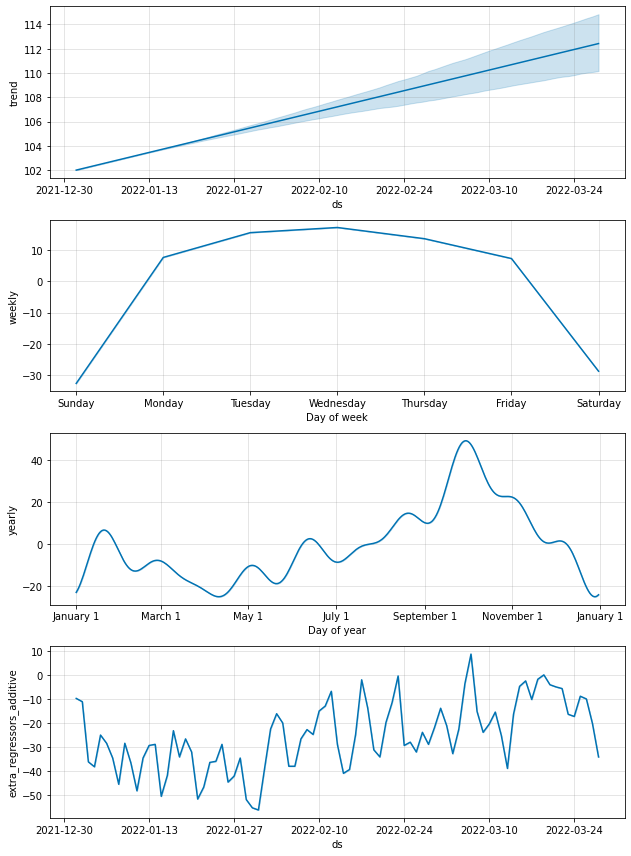

In [89]:
fig1 = m_train_A_ex1.plot_components(prophet_pred_train_A_ex1)

In [90]:
m_train_A_ex2 = Prophet()
m_train_A_ex2.add_regressor('precipitation_mm')
m_train_A_ex2.fit(history_prophet_A)
future_train_A_ex2 = m_train_A_ex2.make_future_dataframe(periods=0,freq='D')
prophet_pred_train_A_ex2 = m_train_A_ex2.predict(future_prophet_A)
prophet_pred_train_A_ex2

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2022-01-01  104.150313  -39.659776   38.193731   104.150313   104.150313   
1  2022-01-02  104.283525  -15.852533   61.424413   104.283525   104.283525   
2  2022-01-03  104.416737   30.058724  107.036271   104.416737   104.416737   
3  2022-01-04  104.549949   36.404903  118.470669   104.549949   104.549949   
4  2022-01-05  104.683161   37.996553  119.798487   104.683161   104.683161   
..        ...         ...         ...         ...          ...          ...   
82 2022-03-24  115.073683   36.733686  116.365642   112.793907   117.350880   
83 2022-03-25  115.206895   55.061833  135.954819   112.856577   117.519793   
84 2022-03-26  115.340107   11.702912   93.908870   112.941058   117.744316   
85 2022-03-27  115.473318   15.035886   93.705936   113.035150   117.967211   
86 2022-03-28  115.606530   52.312830  134.047671   113.130496   118.142674   

    additive_terms  additive_terms_lower  additive_terms_upper  \
0      -104.774827           -104.774827           -104.774827   
1       -81.059625            -81.059625            -81.059625   
2       -35.598736            -35.598736            -35.598736   
3       -23.632039            -23.632039            -23.632039   
4       -24.415522            -24.415522            -24.415522   
..             ...                   ...                   ...   
82      -36.573701            -36.573701            -36.573701   
83      -21.905691            -21.905691            -21.905691   
84      -61.493834            -61.493834            -61.493834   
85      -62.088981            -62.088981            -62.088981   
86      -23.359386            -23.359386            -23.359386   

    extra_regressors_additive  ...     weekly  weekly_lower  weekly_upper  \
0                  -27.862164  ... -30.040316    -30.040316    -30.040316   
1                   -2.080947  ... -32.892984    -32.892984    -32.892984   
2                    1.621674  ...   7.842640      7.842640      7.842640   
3                    5.050028  ...  15.145639     15.145639     15.145639   
4                    0.524601  ...  17.467455     17.467455     17.467455   
..                        ...  ...        ...           ...           ...   
82                 -16.342897  ...  13.954193     13.954193     13.954193   
83                   3.678686  ...   8.523374      8.523374      8.523374   
84                   2.581613  ... -30.040316    -30.040316    -30.040316   
85                   4.775759  ... -32.892984    -32.892984    -32.892984   
86                   2.718748  ...   7.842640      7.842640      7.842640   

       yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0  -46.872347    -46.872347    -46.872347                   0.0   
1  -46.085694    -46.085694    -46.085694                   0.0   
2  -45.063051    -45.063051    -45.063051                   0.0   
3  -43.827706    -43.827706    -43.827706                   0.0   
4  -42.407578    -42.407578    -42.407578                   0.0   
..        ...           ...           ...                   ...   
82 -34.184998    -34.184998    -34.184998                   0.0   
83 -34.107751    -34.107751    -34.107751                   0.0   
84 -34.035131    -34.035131    -34.035131                   0.0   
85 -33.971756    -33.971756    -33.971756                   0.0   
86 -33.920773    -33.920773    -33.920773                   0.0   

    multiplicative_terms_lower  multiplicative_terms_upper       yhat  
0                          0.0                         0.0  -0.624514  
1                          0.0                         0.0  23.223900  
2                          0.0                         0.0  68.818001  
3                          0.0                         0.0  80.917909  
4                          0.0                         0.0  80.267639  
..                         ...                         ...        ...  
82                         0.0     

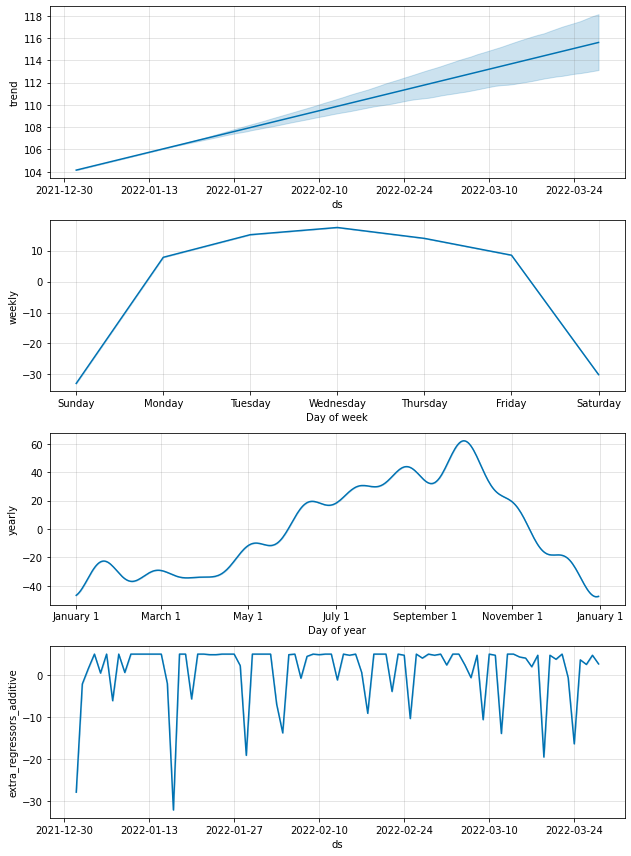

In [91]:
fig2 = m_train_A_ex2.plot_components(prophet_pred_train_A_ex2)

In [92]:
m_train_A_ex3 = Prophet()
m_train_A_ex3.add_regressor('windspeed_km/h')
m_train_A_ex3.fit(history_prophet_A)
future_train_A_ex3 = m_train_A_ex3.make_future_dataframe(periods=0,freq='D')
prophet_pred_train_A_ex3 = m_train_A_ex3.predict(future_prophet_A)
prophet_pred_train_A_ex3

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2022-01-01  103.576140  -16.800505   67.965629   103.576140   103.576140   
1  2022-01-02  103.706531  -23.819527   65.612554   103.706531   103.706531   
2  2022-01-03  103.836923   18.398579  102.556741   103.836923   103.836923   
3  2022-01-04  103.967314   35.790053  120.097408   103.967314   103.967314   
4  2022-01-05  104.097705   35.395066  119.663192   104.097705   104.097705   
..        ...         ...         ...         ...          ...          ...   
82 2022-03-24  114.268229   43.668008  128.557142   112.071450   115.981269   
83 2022-03-25  114.398620   48.300267  132.097848   112.160322   116.134567   
84 2022-03-26  114.529011    7.039312   93.518933   112.271078   116.313478   
85 2022-03-27  114.659403    9.087873   94.371756   112.343929   116.504350   
86 2022-03-28  114.789794   48.576351  136.101815   112.433972   116.685890   

    additive_terms  additive_terms_lower  additive_terms_upper  \
0       -73.472381            -73.472381            -73.472381   
1       -80.654188            -80.654188            -80.654188   
2       -43.157976            -43.157976            -43.157976   
3       -27.263368            -27.263368            -27.263368   
4       -25.034143            -25.034143            -25.034143   
..             ...                   ...                   ...   
82      -27.472726            -27.472726            -27.472726   
83      -25.560224            -25.560224            -25.560224   
84      -64.315025            -64.315025            -64.315025   
85      -64.794502            -64.794502            -64.794502   
86      -23.455664            -23.455664            -23.455664   

    extra_regressors_additive  ...  windspeed_km/h  windspeed_km/h_lower  \
0                    2.242526  ...        2.242526              2.242526   
1                   -2.302499  ...       -2.302499             -2.302499   
2                   -6.329736  ...       -6.329736             -6.329736   
3                    0.343971  ...        0.343971              0.343971   
4                   -0.921732  ...       -0.921732             -0.921732   
..                        ...  ...             ...                   ...   
82                  -8.861142  ...       -8.861142             -8.861142   
83                  -0.691604  ...       -0.691604             -0.691604   
84                  -2.820287  ...       -2.820287             -2.820287   
85                   0.228907  ...        0.228907              0.228907   
86                   1.206950  ...        1.206950              1.206950   

    windspeed_km/h_upper     yearly  yearly_lower  yearly_upper  \
0               2.242526 -46.569704    -46.569704    -46.569704   
1              -2.302499 -45.646393    -45.646393    -45.646393   
2              -6.329736 -44.472846    -44.472846    -44.472846   
3               0.343971 -43.074075    -43.074075    -43.074075   
4              -0.921732 -41.480070    -41.480070    -41.480070   
..                   ...        ...           ...           ...   
82             -8.861142 -32.454669    -32.454669    -32.454669   
83             -0.691604 -32.397033    -32.397033    -32.397033   
84             -2.820287 -32.349536    -32.349536    -32.349536   
85              0.228907 -32.318113    -32.318113    -32.318113   
86              1.206950 -32.307220    -32.307220    -32.307220   

    multiplicative_terms  multiplicative_terms_lower  \
0                    0.0                         0.0   
1                    0.0                         0.0   
2                    0.0                         0.0   
3                    0.0                         0.0   
4                    0.0                         0.0   
..                   ...                         ...   
82                   0.0                         0.0   
83                   0.0                         0.0   
84                   0.0                       

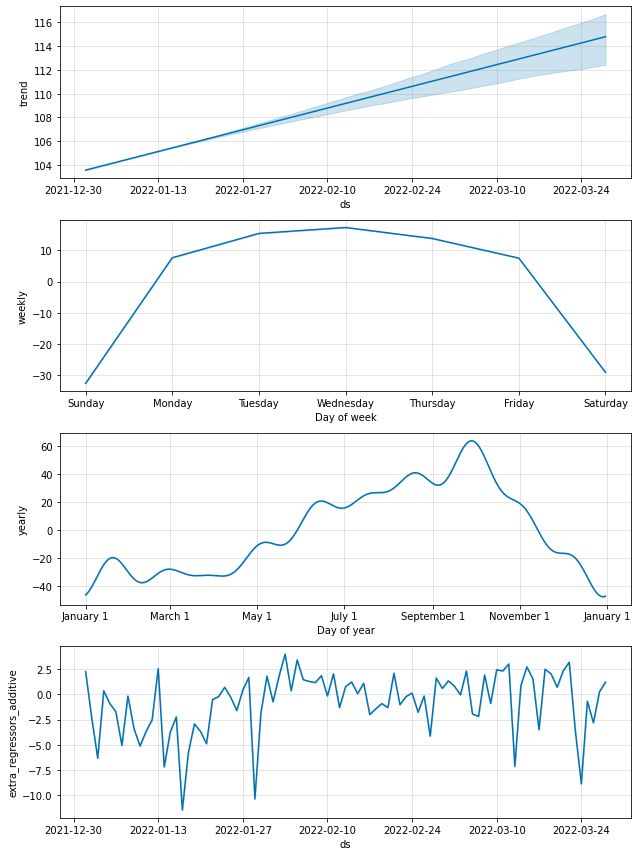

In [93]:
fig3 = m_train_A_ex3.plot_components(prophet_pred_train_A_ex3)

-- Rückgaben

In [94]:
m_train_R_ex1 = Prophet()
m_train_R_ex1.add_regressor('avg_temp_C°')
m_train_R_ex1.fit(history_prophet_R)
future_train_R_ex1 = m_train_R_ex1.make_future_dataframe(periods=0,freq='D')
prophet_pred_train_R_ex1 = m_train_R_ex1.predict(future_prophet_R)
prophet_pred_train_R_ex1

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2022-01-01  100.442710  -25.487781   72.789965   100.442710   100.442710   
1  2022-01-02  100.545059  -43.148617   59.428969   100.545059   100.545059   
2  2022-01-03  100.647409  -19.838144   82.927819   100.647409   100.647409   
3  2022-01-04  100.749758   -1.438476  100.952624   100.749758   100.749758   
4  2022-01-05  100.852108   15.016509  118.646322   100.852108   100.852108   
..        ...         ...         ...         ...          ...          ...   
82 2022-03-24  108.835373   32.155186  127.388733   105.425054   111.850313   
83 2022-03-25  108.937722   39.371887  140.322721   105.427323   112.024105   
84 2022-03-26  109.040072  -16.040387   88.996205   105.428926   112.199123   
85 2022-03-27  109.142421  -40.091943   59.776561   105.469099   112.366062   
86 2022-03-28  109.244771   -0.991650   95.735645   105.524767   112.558079   

    additive_terms  additive_terms_lower  additive_terms_upper  avg_temp_C°  \
0       -78.165457            -78.165457            -78.165457   -11.407184   
1       -91.835172            -91.835172            -91.835172   -12.993078   
2       -67.294690            -67.294690            -67.294690   -42.067801   
3       -51.697880            -51.697880            -51.697880   -44.446642   
4       -33.562246            -33.562246            -33.562246   -29.116333   
..             ...                   ...                   ...          ...   
82      -28.749232            -28.749232            -28.749232   -20.129601   
83      -20.344899            -20.344899            -20.344899   -10.349921   
84      -73.524297            -73.524297            -73.524297   -11.671500   
85      -98.936503            -98.936503            -98.936503   -23.565705   
86      -63.165718            -63.165718            -63.165718   -39.688960   

    ...     weekly  weekly_lower  weekly_upper     yearly  yearly_lower  \
0   ... -34.545521    -34.545521    -34.545521 -32.212752    -32.212752   
1   ... -47.715181    -47.715181    -47.715181 -31.126913    -31.126913   
2   ...   4.533238      4.533238      4.533238 -29.760127    -29.760127   
3   ...  20.892296     20.892296     20.892296 -28.143534    -28.143534   
4   ...  21.867182     21.867182     21.867182 -26.313094    -26.313094   
..  ...        ...           ...           ...        ...           ...   
82  ...  17.999896     17.999896     17.999896 -26.619527    -26.619527   
83  ...  16.968090     16.968090     16.968090 -26.963067    -26.963067   
84  ... -34.545521    -34.545521    -34.545521 -27.307276    -27.307276   
85  ... -47.715181    -47.715181    -47.715181 -27.655618    -27.655618   
86  ...   4.533238      4.533238      4.533238 -28.009996    -28.009996   

    yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0     -32.212752                   0.0                         0.0   
1     -31.126913                   0.0                         0.0   
2     -29.760127                   0.0                         0.0   
3     -28.143534                   0.0                         0.0   
4     -26.313094                   0.0                         0.0   
..           ...                   ...                         ...   
82    -26.619527                   0.0                         0.0   
83    -26.963067                   0.0                         0.0   
84    -27.307276                   0.0                         0.0   
85    -27.655618                   0.0                         0.0   
86    -28.009996                   0.0                         0.0   

    multiplicative_terms_upper       yhat  
0                          0.0  22.277252  
1                          0.0   8.709888  
2                          0.0  33.352719  
3                          0.0  49.051878  
4                          0.0  67.289862  
..                         ...        ...  
82                         0.0  80.086141  
83                 

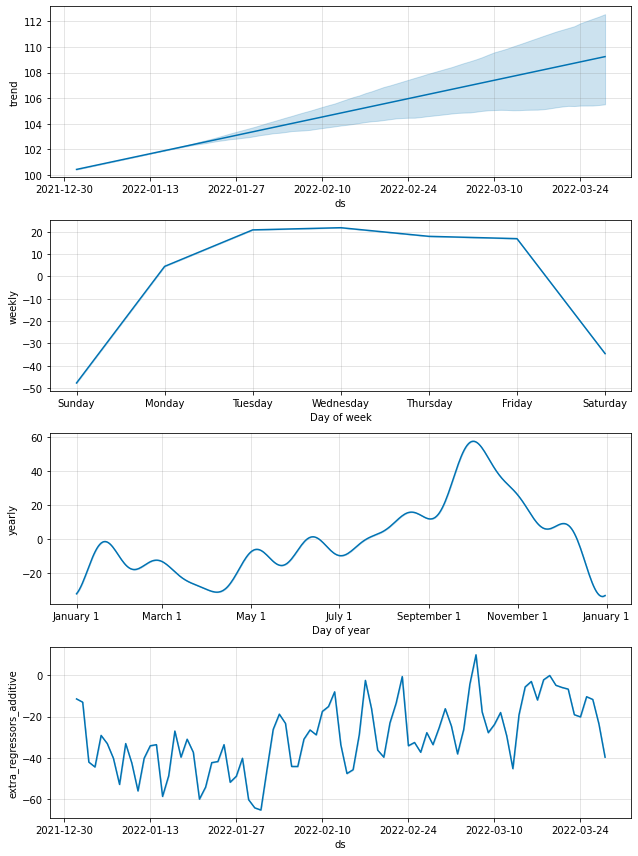

In [95]:
fig4 = m_train_R_ex1.plot_components(prophet_pred_train_R_ex1)

In [96]:
m_train_R_ex2 = Prophet()
m_train_R_ex2.add_regressor('precipitation_mm')
m_train_R_ex2.fit(history_prophet_R)
future_train_R_ex2 = m_train_R_ex2.make_future_dataframe(periods=0,freq='D')
prophet_pred_train_R_ex2 = m_train_R_ex2.predict(future_prophet_R)
prophet_pred_train_R_ex2

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2022-01-01  101.519448  -71.055959   29.014033   101.519448   101.519448   
1  2022-01-02  101.625541  -58.190018   39.775442   101.625541   101.625541   
2  2022-01-03  101.731634    1.320231  100.689376   101.731634   101.731634   
3  2022-01-04  101.837727   18.380264  120.085469   101.837727   101.837727   
4  2022-01-05  101.943820   21.520771  119.962411   101.943820   101.943820   
..        ...         ...         ...         ...          ...          ...   
82 2022-03-24  110.219071   16.441321  115.236922   107.264504   113.090103   
83 2022-03-25  110.325164   38.921567  137.524177   107.294678   113.256663   
84 2022-03-26  110.431257  -16.559835   81.961790   107.362820   113.421070   
85 2022-03-27  110.537350  -24.905421   70.937829   107.399619   113.587309   
86 2022-03-28  110.643443   24.944257  123.037088   107.431981   113.759281   

    additive_terms  additive_terms_lower  additive_terms_upper  \
0      -124.957335           -124.957335           -124.957335   
1      -109.372119           -109.372119           -109.372119   
2       -51.831335            -51.831335            -51.831335   
3       -31.340038            -31.340038            -31.340038   
4       -33.007867            -33.007867            -33.007867   
..             ...                   ...                   ...   
82      -42.984999            -42.984999            -42.984999   
83      -21.923762            -21.923762            -21.923762   
84      -77.140689            -77.140689            -77.140689   
85      -86.756529            -86.756529            -86.756529   
86      -36.015972            -36.015972            -36.015972   

    extra_regressors_additive  ...     weekly  weekly_lower  weekly_upper  \
0                  -29.181737  ... -35.940235    -35.940235    -35.940235   
1                   -2.179502  ... -48.014359    -48.014359    -48.014359   
2                    1.698478  ...   4.721360      4.721360      4.721360   
3                    5.289201  ...  20.453076     20.453076     20.453076   
4                    0.549447  ...  22.147169     22.147169     22.147169   
..                        ...  ...        ...           ...           ...   
82                 -17.116909  ...  18.346908     18.346908     18.346908   
83                   3.852912  ...  18.286080     18.286080     18.286080   
84                   2.703881  ... -35.940235    -35.940235    -35.940235   
85                   5.001943  ... -48.014359    -48.014359    -48.014359   
86                   2.847509  ...   4.721360      4.721360      4.721360   

       yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0  -59.835363    -59.835363    -59.835363                   0.0   
1  -59.178258    -59.178258    -59.178258                   0.0   
2  -58.251172    -58.251172    -58.251172                   0.0   
3  -57.082316    -57.082316    -57.082316                   0.0   
4  -55.704482    -55.704482    -55.704482                   0.0   
..        ...           ...           ...                   ...   
82 -44.214999    -44.214999    -44.214999                   0.0   
83 -44.062754    -44.062754    -44.062754                   0.0   
84 -43.904335    -43.904335    -43.904335                   0.0   
85 -43.744114    -43.744114    -43.744114                   0.0   
86 -43.584841    -43.584841    -43.584841                   0.0   

    multiplicative_terms_lower  multiplicative_terms_upper       yhat  
0                          0.0                         0.0 -23.437886  
1                          0.0                         0.0  -7.746577  
2                          0.0                         0.0  49.900300  
3                          0.0                         0.0  70.497689  
4                          0.0                         0.0  68.935954  
..                         ...                         ...        ...  
82                         0.0     

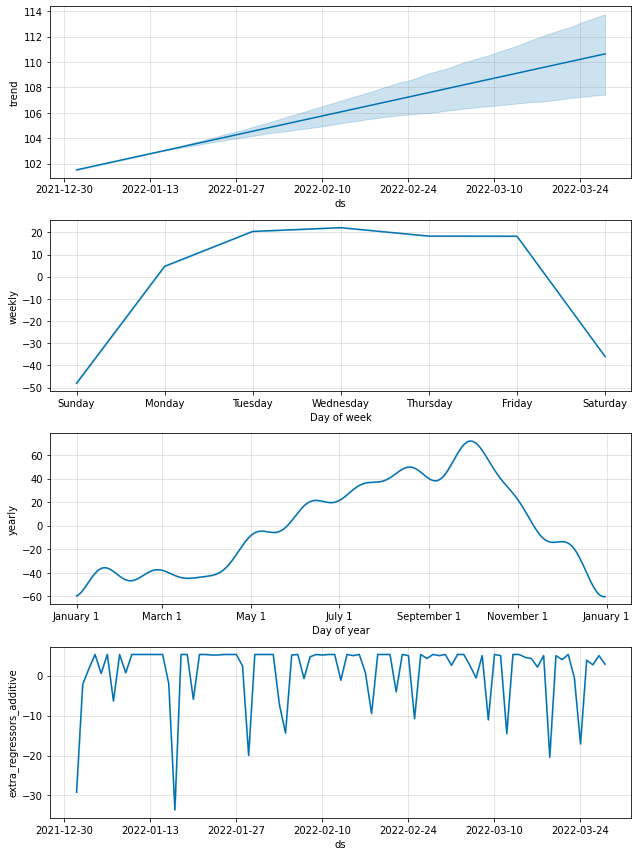

In [97]:
fig5 = m_train_R_ex2.plot_components(prophet_pred_train_R_ex2)

In [98]:
m_train_R_ex3 = Prophet()
m_train_R_ex3.add_regressor('windspeed_km/h')
m_train_R_ex3.fit(history_prophet_R)
future_train_R_ex3 = m_train_R_ex3.make_future_dataframe(periods=0,freq='D')
prophet_pred_train_R_ex3 = m_train_R_ex3.predict(future_prophet_R)
prophet_pred_train_R_ex3

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2022-01-01  101.858116  -45.291621   66.087310   101.858116   101.858116   
1  2022-01-02  101.965360  -57.023481   45.673200   101.965360   101.965360   
2  2022-01-03  102.072604   -7.979806   96.133373   102.072604   102.072604   
3  2022-01-04  102.179848   14.710029  115.367198   102.179848   102.179848   
4  2022-01-05  102.287093   16.480539  121.671855   102.287093   102.287093   
..        ...         ...         ...         ...          ...          ...   
82 2022-03-24  110.652149   23.980814  132.845458   107.747193   113.597065   
83 2022-03-25  110.759394   31.291445  135.377036   107.778668   113.744177   
84 2022-03-26  110.866638  -20.396327   82.971807   107.803481   113.992049   
85 2022-03-27  110.973882  -30.047306   73.402280   107.834640   114.237253   
86 2022-03-28  111.081127   23.899005  124.806259   107.891129   114.481511   

    additive_terms  additive_terms_lower  additive_terms_upper  \
0       -92.337091            -92.337091            -92.337091   
1      -108.583148           -108.583148           -108.583148   
2       -58.840902            -58.840902            -58.840902   
3       -35.011880            -35.011880            -35.011880   
4       -33.376601            -33.376601            -33.376601   
..             ...                   ...                   ...   
82      -32.472130            -32.472130            -32.472130   
83      -25.779187            -25.779187            -25.779187   
84      -79.829670            -79.829670            -79.829670   
85      -89.755702            -89.755702            -89.755702   
86      -36.376223            -36.376223            -36.376223   

    extra_regressors_additive  ...  windspeed_km/h  windspeed_km/h_lower  \
0                    2.069487  ...        2.069487              2.069487   
1                   -2.124833  ...       -2.124833             -2.124833   
2                   -5.841319  ...       -5.841319             -5.841319   
3                    0.317429  ...        0.317429              0.317429   
4                   -0.850609  ...       -0.850609             -0.850609   
..                        ...  ...             ...                   ...   
82                  -8.177396  ...       -8.177396             -8.177396   
83                  -0.638238  ...       -0.638238             -0.638238   
84                  -2.602667  ...       -2.602667             -2.602667   
85                   0.211244  ...        0.211244              0.211244   
86                   1.113819  ...        1.113819              1.113819   

    windspeed_km/h_upper     yearly  yearly_lower  yearly_upper  \
0               2.069487 -59.424280    -59.424280    -59.424280   
1              -2.124833 -58.605622    -58.605622    -58.605622   
2              -5.841319 -57.503525    -57.503525    -57.503525   
3               0.317429 -56.148233    -56.148233    -56.148233   
4              -0.850609 -54.574904    -54.574904    -54.574904   
..                   ...        ...           ...           ...   
82             -8.177396 -42.517745    -42.517745    -42.517745   
83             -0.638238 -42.381151    -42.381151    -42.381151   
84             -2.602667 -42.244705    -42.244705    -42.244705   
85              0.211244 -42.114253    -42.114253    -42.114253   
86              1.113819 -41.993984    -41.993984    -41.993984   

    multiplicative_terms  multiplicative_terms_lower  \
0                    0.0                         0.0   
1                    0.0                         0.0   
2                    0.0                         0.0   
3                    0.0                         0.0   
4                    0.0                         0.0   
..                   ...                         ...   
82                   0.0                         0.0   
83                   0.0                         0.0   
84                   0.0                       

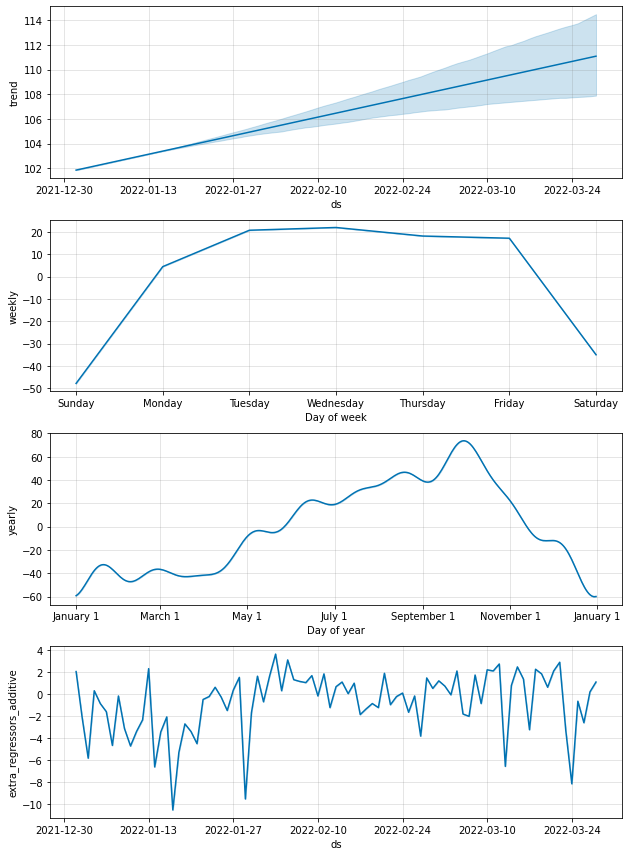

In [99]:
fig6 = m_train_R_ex3.plot_components(prophet_pred_train_R_ex3)

--Werte der Prognose

-Ausleihen

In [100]:
prophet_pred_train_A_ex1 = pd.DataFrame({'time': prophet_pred_train_A_ex1[-1584:]['ds'], 'Test_Prophet_Predictions_A': prophet_pred_train_A_ex1[-1584:]['yhat']})
prophet_pred_train_A_ex1 = prophet_pred_train_A_ex1.set_index('time')
prophet_pred_train_A_ex1.index.freq = 'D'
prophet_pred_train_A_ex1.tail(248)

Test_Prophet_Predictions_A
time                                  
2022-01-01                   40.157225
2022-01-02                   36.150377
2022-01-03                   52.948107
2022-01-04                   60.560101
2022-01-05                   77.309608
...                                ...
2022-03-24                   89.288473
2022-03-25                   91.132952
2022-03-26                   53.740441
2022-03-27                   39.360785
2022-03-28                   65.524611

[87 rows x 1 columns]

In [101]:
prophet_pred_train_A_ex2 = pd.DataFrame({'time': prophet_pred_train_A_ex2[-1584:]['ds'], 'Test_Prophet_Predictions_A': prophet_pred_train_A_ex2[-1584:]['yhat']})
prophet_pred_train_A_ex2 = prophet_pred_train_A_ex2.set_index('time')
prophet_pred_train_A_ex2.index.freq = 'D'
prophet_pred_train_A_ex2.tail(248)

Test_Prophet_Predictions_A
time                                  
2022-01-01                   -0.624514
2022-01-02                   23.223900
2022-01-03                   68.818001
2022-01-04                   80.917909
2022-01-05                   80.267639
...                                ...
2022-03-24                   78.499982
2022-03-25                   93.301204
2022-03-26                   53.846273
2022-03-27                   53.384337
2022-03-28                   92.247145

[87 rows x 1 columns]

In [102]:
prophet_pred_train_A_ex3 = pd.DataFrame({'time': prophet_pred_train_A_ex3[-1584:]['ds'], 'Test_Prophet_Predictions_A': prophet_pred_train_A_ex3[-1584:]['yhat']})
prophet_pred_train_A_ex3 = prophet_pred_train_A_ex3.set_index('time')
prophet_pred_train_A_ex3.index.freq = 'D'
prophet_pred_train_A_ex3.tail(248)

Test_Prophet_Predictions_A
time                                  
2022-01-01                   30.103759
2022-01-02                   23.052343
2022-01-03                   60.678946
2022-01-04                   76.703946
2022-01-05                   79.063562
...                                ...
2022-03-24                   86.795503
2022-03-25                   88.838396
2022-03-26                   50.213986
2022-03-27                   49.864900
2022-03-28                   91.334130

[87 rows x 1 columns]

-Rückgaben

In [103]:
prophet_pred_train_R_ex1 = pd.DataFrame({'time': prophet_pred_train_R_ex1[-1584:]['ds'], 'Test_Prophet_Predictions_R': prophet_pred_train_R_ex1[-1584:]['yhat']})
prophet_pred_train_R_ex1 = prophet_pred_train_R_ex1.set_index('time')
prophet_pred_train_R_ex1.index.freq = 'D'
prophet_pred_train_R_ex1.tail(248)

Test_Prophet_Predictions_R
time                                  
2022-01-01                   22.277252
2022-01-02                    8.709888
2022-01-03                   33.352719
2022-01-04                   49.051878
2022-01-05                   67.289862
...                                ...
2022-03-24                   80.086141
2022-03-25                   88.592824
2022-03-26                   35.515775
2022-03-27                   10.205919
2022-03-28                   46.079052

[87 rows x 1 columns]

In [104]:
prophet_pred_train_R_ex2 = pd.DataFrame({'time': prophet_pred_train_R_ex2[-1584:]['ds'], 'Test_Prophet_Predictions_R': prophet_pred_train_R_ex2[-1584:]['yhat']})
prophet_pred_train_R_ex2 = prophet_pred_train_R_ex2.set_index('time')
prophet_pred_train_R_ex2.index.freq = 'D'
prophet_pred_train_R_ex2.tail(248)

Test_Prophet_Predictions_R
time                                  
2022-01-01                  -23.437886
2022-01-02                   -7.746577
2022-01-03                   49.900300
2022-01-04                   70.497689
2022-01-05                   68.935954
...                                ...
2022-03-24                   67.234072
2022-03-25                   88.401402
2022-03-26                   33.290568
2022-03-27                   23.780821
2022-03-28                   74.627471

[87 rows x 1 columns]

In [105]:
prophet_pred_train_R_ex3 = pd.DataFrame({'time': prophet_pred_train_R_ex3[-1584:]['ds'], 'Test_Prophet_Predictions_R': prophet_pred_train_R_ex3[-1584:]['yhat']})
prophet_pred_train_R_ex3 = prophet_pred_train_R_ex3.set_index('time')
prophet_pred_train_R_ex3.index.freq = 'D'
prophet_pred_train_R_ex3.tail(248)

Test_Prophet_Predictions_R
time                                  
2022-01-01                    9.521025
2022-01-02                   -6.617788
2022-01-03                   43.231702
2022-01-04                   67.167969
2022-01-05                   68.910492
...                                ...
2022-03-24                   78.180019
2022-03-25                   84.980207
2022-03-26                   31.036968
2022-03-27                   21.218180
2022-03-28                   74.704904

[87 rows x 1 columns]

--Grafiken der Prognose

-Ausleihen

<AxesSubplot:xlabel='time'>

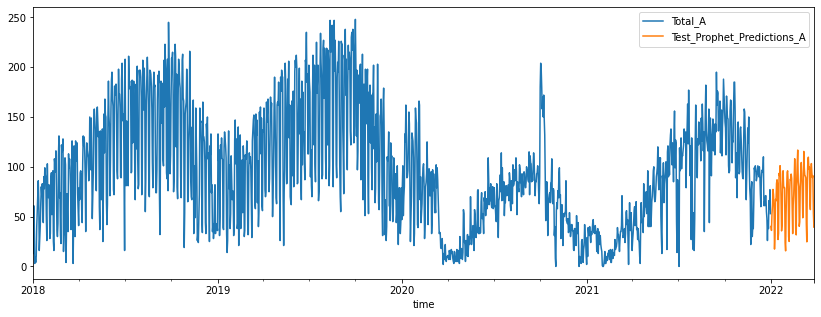

In [106]:
history_prophet_A['Total_A'].plot(figsize=(14,5), legend=True)
prophet_pred_train_A_ex1['Test_Prophet_Predictions_A'].plot(legend=True)

<AxesSubplot:xlabel='time'>

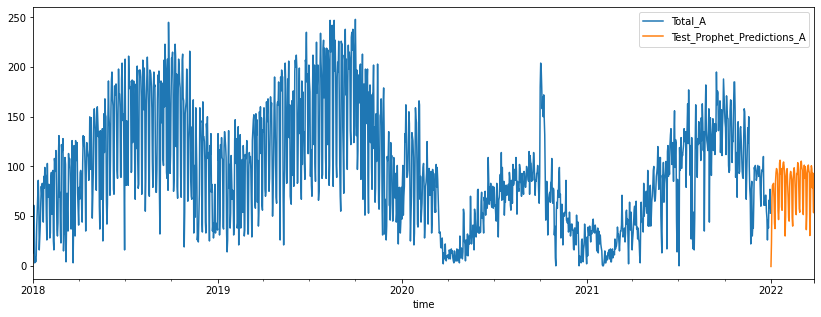

In [107]:
history_prophet_A['Total_A'].plot(figsize=(14,5), legend=True)
prophet_pred_train_A_ex2['Test_Prophet_Predictions_A'].plot(legend=True)

<AxesSubplot:xlabel='time'>

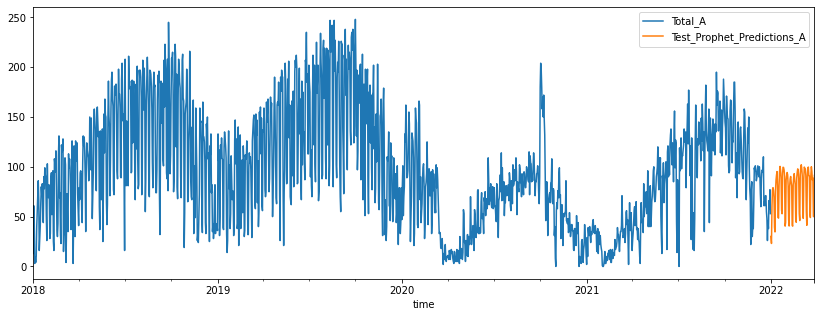

In [108]:
history_prophet_A['Total_A'].plot(figsize=(14,5), legend=True)
prophet_pred_train_A_ex3['Test_Prophet_Predictions_A'].plot(legend=True)

-Rückgaben

<AxesSubplot:xlabel='time'>

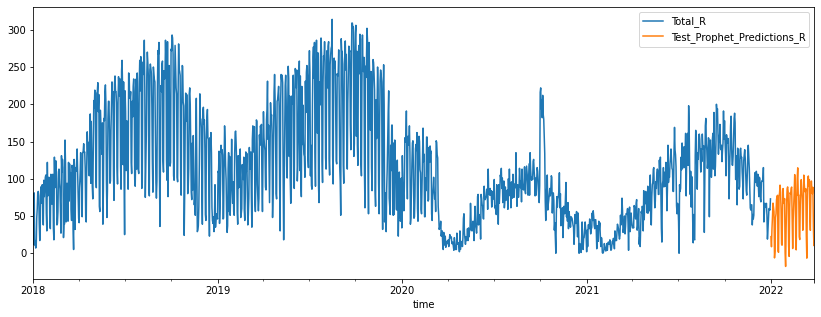

In [109]:
history_prophet_R['Total_R'].plot(figsize=(14,5), legend=True)
prophet_pred_train_R_ex1['Test_Prophet_Predictions_R'].plot(legend=True)

<AxesSubplot:xlabel='time'>

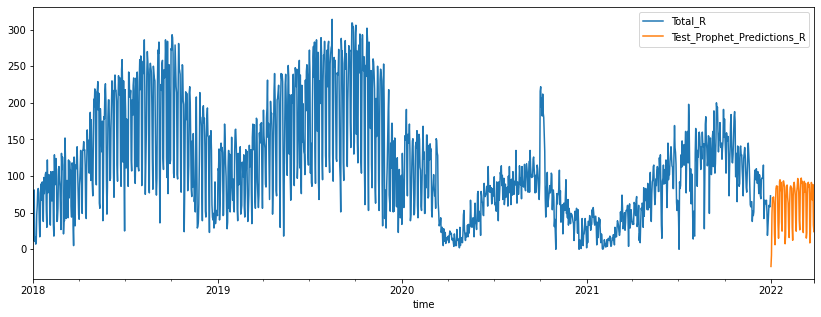

In [110]:
history_prophet_R['Total_R'].plot(figsize=(14,5), legend=True)
prophet_pred_train_R_ex2['Test_Prophet_Predictions_R'].plot(legend=True)

<AxesSubplot:xlabel='time'>

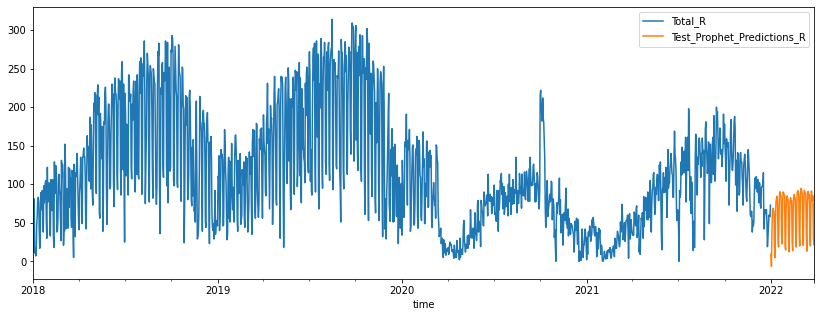

In [111]:
history_prophet_R['Total_R'].plot(figsize=(14,5), legend=True)
prophet_pred_train_R_ex3['Test_Prophet_Predictions_R'].plot(legend=True)

---Prognose der test-Daten

--Ausleihen

In [112]:
train_prophet_A = bike_prophet_AW[:1461]
test_prophet_A = bike_prophet_AW[-59:]

train_prophet_R = bike_prophet_RW[:1461]
test_prophet_R = bike_prophet_RW[-59:]

In [113]:
m_train_A_ex1_2 = Prophet()
m_train_A_ex1_2.add_regressor('avg_temp_C°')
m_train_A_ex1_2.fit(train_prophet_A)
future_train_A_ex1_2 = m_train_A_ex1_2.make_future_dataframe(periods=0,freq='D')
prophet_pred_train_A_ex1_2 = m_train_A_ex1_2.predict(test_prophet_A)
prophet_pred_train_A_ex1_2.tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
54 2022-02-24  108.545033   42.756365  130.166642   107.519483   109.614136   
55 2022-02-25  108.666278   38.570313  124.205620   107.599951   109.793079   
56 2022-02-26  108.787523   -0.106921   82.955972   107.699003   109.962888   
57 2022-02-27  108.908768    1.598793   83.861605   107.779649   110.126494   
58 2022-02-28  109.030013   38.801118  124.106627   107.858023   110.286418   

    additive_terms  additive_terms_lower  additive_terms_upper  avg_temp_C°  \
54      -23.764317            -23.764317            -23.764317   -29.358015   
55      -28.544485            -28.544485            -28.544485   -27.994190   
56      -68.552651            -68.552651            -68.552651   -32.085664   
57      -64.263563            -64.263563            -64.263563   -23.902716   
58      -29.058067            -29.058067            -29.058067   -28.903406   

    ...     weekly  weekly_lower  weekly_upper    yearly  yearly_lower  \
54  ...  13.640253     13.640253     13.640253 -8.046556     -8.046556   
55  ...   7.292267      7.292267      7.292267 -7.842561     -7.842561   
56  ... -28.734940    -28.734940    -28.734940 -7.732046     -7.732046   
57  ... -32.642113    -32.642113    -32.642113 -7.718735     -7.718735   
58  ...   7.648685      7.648685      7.648685 -7.803345     -7.803345   

    yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
54     -8.046556                   0.0                         0.0   
55     -7.842561                   0.0                         0.0   
56     -7.732046                   0.0                         0.0   
57     -7.718735                   0.0                         0.0   
58     -7.803345                   0.0                         0.0   

    multiplicative_terms_upper       yhat  
54                         0.0  84.780716  
55                         0.0  80.121793  
56                         0.0  40.234872  
57                         0.0  44.645205  
58                         0.0  79.971947  

[5 rows x 25 columns]

In [114]:
m_train_A_ex2_2 = Prophet()
m_train_A_ex2_2.add_regressor('precipitation_mm')
m_train_A_ex2_2.fit(train_prophet_A)
future_train_A_ex2_2 = m_train_A_ex2_2.make_future_dataframe(periods=0,freq='D')
prophet_pred_train_A_ex2_2 = m_train_A_ex2_2.predict(test_prophet_A)
prophet_pred_train_A_ex2_2.tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
54 2022-02-24  111.343752   61.328033  137.306572   110.172695   112.333136   
55 2022-02-25  111.476964   41.348986  123.159063   110.268913   112.500503   
56 2022-02-26  111.610176   16.443757   96.732761   110.344957   112.668393   
57 2022-02-27  111.743387   11.051530   96.527239   110.432989   112.850229   
58 2022-02-28  111.876599   57.474849  138.692887   110.516027   113.055250   

    additive_terms  additive_terms_lower  additive_terms_upper  \
54      -10.815636            -10.815636            -10.815636   
55      -31.057538            -31.057538            -31.057538   
56      -54.085063            -54.085063            -54.085063   
57      -57.817782            -57.817782            -57.817782   
58      -16.137367            -16.137367            -16.137367   

    extra_regressors_additive  ...     weekly  weekly_lower  weekly_upper  \
54                   4.775759  ...  13.954193     13.954193     13.954193   
55                 -10.308995  ...   8.523374      8.523374      8.523374   
56                   5.050028  ... -30.040316    -30.040316    -30.040316   
57                   4.090089  ... -32.892984    -32.892984    -32.892984   
58                   5.050028  ...   7.842640      7.842640      7.842640   

       yearly  yearly_lower  yearly_upper  multiplicative_terms  \
54 -29.545588    -29.545588    -29.545588                   0.0   
55 -29.271917    -29.271917    -29.271917                   0.0   
56 -29.094775    -29.094775    -29.094775                   0.0   
57 -29.014887    -29.014887    -29.014887                   0.0   
58 -29.030034    -29.030034    -29.030034                   0.0   

    multiplicative_terms_lower  multiplicative_terms_upper        yhat  
54                         0.0                         0.0  100.528116  
55                         0.0                         0.0   80.419425  
56                         0.0                         0.0   57.525112  
57                         0.0                         0.0   53.925606  
58                         0.0                         0.0   95.739233  

[5 rows x 25 columns]

In [115]:
m_train_A_ex3_2 = Prophet()
m_train_A_ex3_2.add_regressor('windspeed_km/h')
m_train_A_ex3_2.fit(train_prophet_A)
future_train_A_ex3_2 = m_train_A_ex3_2.make_future_dataframe(periods=0,freq='D')
prophet_pred_train_A_ex3_2 = m_train_A_ex3_2.predict(test_prophet_A)
prophet_pred_train_A_ex3_2.tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
54 2022-02-24  110.617272   51.939347  138.421649   109.661052   111.664540   
55 2022-02-25  110.747663   44.757075  127.683336   109.737229   111.834237   
56 2022-02-26  110.878054   11.397334   93.050438   109.826384   111.987284   
57 2022-02-27  111.008446    2.236721   86.125035   109.920992   112.139518   
58 2022-02-28  111.138837   48.216285  132.740273   110.022388   112.291264   

    additive_terms  additive_terms_lower  additive_terms_upper  \
54      -15.179241            -15.179241            -15.179241   
55      -22.952584            -22.952584            -22.952584   
56      -57.676872            -57.676872            -57.676872   
57      -64.972792            -64.972792            -64.972792   
58      -18.740195            -18.740195            -18.740195   

    extra_regressors_additive  ...  windspeed_km/h  windspeed_km/h_lower  \
54                   0.113843  ...        0.113843              0.113843   
55                  -1.784711  ...       -1.784711             -1.784711   
56                  -0.173817  ...       -0.173817             -0.173817   
57                  -4.143522  ...       -4.143522             -4.143522   
58                   1.609674  ...        1.609674              1.609674   

    windspeed_km/h_upper     yearly  yearly_lower  yearly_upper  \
54              0.113843 -29.136169    -29.136169    -29.136169   
55             -1.784711 -28.696286    -28.696286    -28.696286   
56             -0.173817 -28.357852    -28.357852    -28.357852   
57             -4.143522 -28.123974    -28.123974    -28.123974   
58              1.609674 -27.994475    -27.994475    -27.994475   

    multiplicative_terms  multiplicative_terms_lower  \
54                   0.0                         0.0   
55                   0.0                         0.0   
56                   0.0                         0.0   
57                   0.0                         0.0   
58                   0.0                         0.0   

    multiplicative_terms_upper       yhat  
54                         0.0  95.438031  
55                         0.0  87.795079  
56                         0.0  53.201182  
57                         0.0  46.035654  
58                         0.0  92.398642  

[5 rows x 25 columns]

--Rückgaben

In [116]:
m_train_R_ex1_2 = Prophet()
m_train_R_ex1_2.add_regressor('avg_temp_C°')
m_train_R_ex1_2.fit(train_prophet_R)
future_train_R_ex1_2 = m_train_R_ex1_2.make_future_dataframe(periods=0,freq='D')
prophet_pred_train_R_ex1_2 = m_train_R_ex1_2.predict(test_prophet_R)
prophet_pred_train_R_ex1_2.tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
54 2022-02-24  105.969585   26.816973  127.462961   104.706169   107.360038   
55 2022-02-25  106.071935   28.046690  130.320283   104.781554   107.521122   
56 2022-02-26  106.174285  -25.269629   71.777403   104.820053   107.669495   
57 2022-02-27  106.276634  -30.240939   66.850081   104.883876   107.810043   
58 2022-02-28  106.378984   12.168247  112.762644   104.925690   107.950627   

    additive_terms  additive_terms_lower  additive_terms_upper  avg_temp_C°  \
54      -28.451746            -28.451746            -28.451746   -34.138331   
55      -27.809553            -27.809553            -27.809553   -32.552437   
56      -84.102751            -84.102751            -84.102751   -37.310119   
57      -87.890367            -87.890367            -87.890367   -27.794755   
58      -41.699918            -41.699918            -41.699918   -33.609700   

    ...     weekly  weekly_lower  weekly_upper     yearly  yearly_lower  \
54  ...  17.999896     17.999896     17.999896 -12.313311    -12.313311   
55  ...  16.968090     16.968090     16.968090 -12.225206    -12.225206   
56  ... -34.545521    -34.545521    -34.545521 -12.247110    -12.247110   
57  ... -47.715181    -47.715181    -47.715181 -12.380431    -12.380431   
58  ...   4.533238      4.533238      4.533238 -12.623455    -12.623455   

    yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
54    -12.313311                   0.0                         0.0   
55    -12.225206                   0.0                         0.0   
56    -12.247110                   0.0                         0.0   
57    -12.380431                   0.0                         0.0   
58    -12.623455                   0.0                         0.0   

    multiplicative_terms_upper       yhat  
54                         0.0  77.517840  
55                         0.0  78.262382  
56                         0.0  22.071534  
57                         0.0  18.386267  
58                         0.0  64.679066  

[5 rows x 25 columns]

In [117]:
m_train_R_ex2_2 = Prophet()
m_train_R_ex2_2.add_regressor('precipitation_mm')
m_train_R_ex2_2.fit(train_prophet_R)
future_train_R_ex2_2 = m_train_R_ex2_2.make_future_dataframe(periods=0,freq='D')
prophet_pred_train_R_ex2_2 = m_train_R_ex2_2.predict(test_prophet_R)
prophet_pred_train_R_ex2_2.tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
54 2022-02-24  107.248468   48.220053  142.266026   105.649267   108.968060   
55 2022-02-25  107.354561   26.852861  128.156519   105.711644   109.134863   
56 2022-02-26  107.460654  -10.345626   87.140248   105.740019   109.269574   
57 2022-02-27  107.566747  -25.396893   73.010547   105.777425   109.442662   
58 2022-02-28  107.672840   29.965012  128.582680   105.815099   109.633974   

    additive_terms  additive_terms_lower  additive_terms_upper  \
54      -14.248134            -14.248134            -14.248134   
55      -29.919525            -29.919525            -29.919525   
56      -67.984581            -67.984581            -67.984581   
57      -81.101191            -81.101191            -81.101191   
58      -27.504097            -27.504097            -27.504097   

    extra_regressors_additive  ...     weekly  weekly_lower  weekly_upper  \
54                   5.001943  ...  18.346908     18.346908     18.346908   
55                 -10.797237  ...  18.286080     18.286080     18.286080   
56                   5.289201  ... -35.940235    -35.940235    -35.940235   
57                   4.283799  ... -48.014359    -48.014359    -48.014359   
58                   5.289201  ...   4.721360      4.721360      4.721360   

       yearly  yearly_lower  yearly_upper  multiplicative_terms  \
54 -37.596985    -37.596985    -37.596985                   0.0   
55 -37.408368    -37.408368    -37.408368                   0.0   
56 -37.333547    -37.333547    -37.333547                   0.0   
57 -37.370631    -37.370631    -37.370631                   0.0   
58 -37.514658    -37.514658    -37.514658                   0.0   

    multiplicative_terms_lower  multiplicative_terms_upper       yhat  
54                         0.0                         0.0  93.000334  
55                         0.0                         0.0  77.435036  
56                         0.0                         0.0  39.476073  
57                         0.0                         0.0  26.465556  
58                         0.0                         0.0  80.168743  

[5 rows x 25 columns]

In [118]:
m_train_R_ex3_2 = Prophet()
m_train_R_ex3_2.add_regressor('windspeed_km/h')
m_train_R_ex3_2.fit(train_prophet_R)
future_train_R_ex3_2 = m_train_R_ex3_2.make_future_dataframe(periods=0,freq='D')
prophet_pred_train_R_ex3_2 = m_train_R_ex3_2.predict(test_prophet_R)
prophet_pred_train_R_ex3_2.tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
54 2022-02-24  107.649308   37.905312  143.079840   106.268164   109.038647   
55 2022-02-25  107.756553   33.981347  135.753810   106.325703   109.199930   
56 2022-02-26  107.863797  -14.641140   88.495033   106.377677   109.361665   
57 2022-02-27  107.971041  -35.831370   69.848787   106.408792   109.518755   
58 2022-02-28  108.078286   25.659696  130.992997   106.457807   109.702384   

    additive_terms  additive_terms_lower  additive_terms_upper  \
54      -18.832765            -18.832765            -18.832765   
55      -21.219868            -21.219868            -21.219868   
56      -71.727335            -71.727335            -71.727335   
57      -88.152379            -88.152379            -88.152379   
58      -30.494369            -30.494369            -30.494369   

    extra_regressors_additive  ...  windspeed_km/h  windspeed_km/h_lower  \
54                   0.105059  ...        0.105059              0.105059   
55                  -1.646999  ...       -1.646999             -1.646999   
56                  -0.160405  ...       -0.160405             -0.160405   
57                  -3.823798  ...       -3.823798             -3.823798   
58                   1.485468  ...        1.485468              1.485468   

    windspeed_km/h_upper     yearly  yearly_lower  yearly_upper  \
54              0.105059 -37.160835    -37.160835    -37.160835   
55             -1.646999 -36.813072    -36.813072    -36.813072   
56             -0.160405 -36.584633    -36.584633    -36.584633   
57             -3.823798 -36.475889    -36.475889    -36.475889   
58              1.485468 -36.483779    -36.483779    -36.483779   

    multiplicative_terms  multiplicative_terms_lower  \
54                   0.0                         0.0   
55                   0.0                         0.0   
56                   0.0                         0.0   
57                   0.0                         0.0   
58                   0.0                         0.0   

    multiplicative_terms_upper       yhat  
54                         0.0  88.816543  
55                         0.0  86.536685  
56                         0.0  36.136462  
57                         0.0  19.818662  
58                         0.0  77.583917  

[5 rows x 25 columns]

---Werte der Prognosen

--Ausleihen

In [119]:
prophet_pred_train_A_ex1_2 = pd.DataFrame({'time': prophet_pred_train_A_ex1_2[-1520:]['ds'], 'Test_Prophet_Predictions_A': prophet_pred_train_A_ex1_2[-1520:]['yhat']})
prophet_pred_train_A_ex1_2 = prophet_pred_train_A_ex1_2.set_index('time')
prophet_pred_train_A_ex1_2.index.freq = 'D'
prophet_pred_train_A_ex1_2.tail(59)

Test_Prophet_Predictions_A
time                                  
2022-01-01                   40.157225
2022-01-02                   36.150377
2022-01-03                   52.948107
2022-01-04                   60.560101
2022-01-05                   77.309608
2022-01-06                   72.396218
2022-01-07                   62.104621
2022-01-08                   17.437255
2022-01-09                   32.883204
2022-01-10                   67.288777
2022-01-11                   65.871212
2022-01-12                   83.312448
2022-01-13                   86.990223
2022-01-14                   82.963727
2022-01-15                   27.015694
2022-01-16                   33.199244
2022-01-17                   93.341422
2022-01-18                   91.314172
2022-01-19                  101.151558
2022-01-20                   92.539266
2022-01-21                   66.800730
2022-01-22                   35.674878
2022-01-23                   41.654165
2022-01-24                   81.833495
2022-01-25                   96.040238
2022-01-26                   81.061472
2022-01-27                   78.898939
2022-01-28                   78.858455
2022-01-29                   24.285401
2022-01-30                   15.654725
2022-01-31                   53.712710
2022-02-01                   77.386346
2022-02-02                   94.376381
2022-02-03                   95.993122
2022-02-04                   84.717927
2022-02-05                   29.795638
2022-02-06                   25.091546
2022-02-07                   76.103456
2022-02-08                   87.410237
2022-02-09                   86.687638
2022-02-10                   92.720250
2022-02-11                   88.410862
2022-02-12                   58.657819
2022-02-13                   32.969633
2022-02-14                   61.594845
2022-02-15                   71.589513
2022-02-16                   88.333306
2022-02-17                  108.088085
2022-02-18                   90.555821
2022-02-19                   37.898299
2022-02-20                   31.669291
2022-02-21                   86.882141
2022-02-22                  103.544900
2022-02-23                  116.816529
2022-02-24                   84.780716
2022-02-25                   80.121793
2022-02-26                   40.234872
2022-02-27                   44.645205
2022-02-28                   79.971947

In [120]:
prophet_pred_train_A_ex2_2 = pd.DataFrame({'time': prophet_pred_train_A_ex2_2[-1520:]['ds'], 'Test_Prophet_Predictions_A': prophet_pred_train_A_ex2_2[-1520:]['yhat']})
prophet_pred_train_A_ex2_2 = prophet_pred_train_A_ex2_2.set_index('time')
prophet_pred_train_A_ex2_2.index.freq = 'D'
prophet_pred_train_A_ex2_2.tail(59)

Test_Prophet_Predictions_A
time                                  
2022-01-01                   -0.624514
2022-01-02                   23.223900
2022-01-03                   68.818001
2022-01-04                   80.917909
2022-01-05                   80.267639
2022-01-06                   82.986065
2022-01-07                   68.271548
2022-01-08                   42.720493
2022-01-09                   37.426234
2022-01-10                   84.499697
2022-01-11                   93.716534
2022-01-12                   97.879394
2022-01-13                   96.099647
2022-01-14                   92.263244
2022-01-15                   55.127195
2022-01-16                   46.518380
2022-01-17                   58.114071
2022-01-18                  103.389060
2022-01-19                  106.291333
2022-01-20                   92.432267
2022-01-21                   97.822705
2022-01-22                   59.167214
2022-01-23                   55.883245
2022-01-24                   96.141061
2022-01-25                  102.942367
2022-01-26                  104.490178
2022-01-27                  100.096048
2022-01-28                   90.964803
2022-01-29                   30.004412
2022-01-30                   50.268404
2022-01-31                   89.999993
2022-02-01                   96.342406
2022-02-02                   97.773370
2022-02-03                   81.531732
2022-02-04                   68.559647
2022-02-05                   48.090970
2022-02-06                   44.961580
2022-02-07                   79.672824
2022-02-08                   92.074638
2022-02-09                   94.984226
2022-02-10                   91.519509
2022-02-11                   86.549037
2022-02-12                   48.433746
2022-02-13                   39.968313
2022-02-14                   87.525380
2022-02-15                   95.277096
2022-02-16                   98.647988
2022-02-17                   91.551758
2022-02-18                   77.199026
2022-02-19                   53.563517
2022-02-20                   51.483695
2022-02-21                   92.944150
2022-02-22                   91.994961
2022-02-23                  103.816014
2022-02-24                  100.528116
2022-02-25                   80.419425
2022-02-26                   57.525112
2022-02-27                   53.925606
2022-02-28                   95.739233

In [121]:
prophet_pred_train_A_ex3_2 = pd.DataFrame({'time': prophet_pred_train_A_ex3_2[-1520:]['ds'], 'Test_Prophet_Predictions_A': prophet_pred_train_A_ex3_2[-1520:]['yhat']})
prophet_pred_train_A_ex3_2 = prophet_pred_train_A_ex3_2.set_index('time')
prophet_pred_train_A_ex3_2.index.freq = 'D'
prophet_pred_train_A_ex3_2.tail(59)

Test_Prophet_Predictions_A
time                                  
2022-01-01                   30.103759
2022-01-02                   23.052343
2022-01-03                   60.678946
2022-01-04                   76.703946
2022-01-05                   79.063562
2022-01-06                   76.618912
2022-01-07                   68.976035
2022-01-08                   39.284322
2022-01-09                   34.635366
2022-01-10                   75.391123
2022-01-11                   86.740359
2022-01-12                   91.797292
2022-01-13                   95.219455
2022-01-14                   80.909661
2022-01-15                   49.229002
2022-01-16                   48.493243
2022-01-17                   80.733554
2022-01-18                   95.099212
2022-01-19                  100.410766
2022-01-20                   96.471043
2022-01-21                   89.025762
2022-01-22                   56.556409
2022-01-23                   52.885104
2022-01-24                   93.546006
2022-01-25                   99.594450
2022-01-26                   99.218605
2022-01-27                   96.627400
2022-01-28                   90.404725
2022-01-29                   40.474219
2022-01-30                   44.171886
2022-01-31                   86.899225
2022-02-01                   90.985466
2022-02-02                   94.286373
2022-02-03                   91.917156
2022-02-04                   81.071618
2022-02-05                   46.685205
2022-02-06                   40.566798
2022-02-07                   80.312327
2022-02-08                   87.763919
2022-02-09                   90.277097
2022-02-10                   84.834491
2022-02-11                   80.967309
2022-02-12                   41.371758
2022-02-13                   40.435802
2022-02-14                   81.918463
2022-02-15                   89.361082
2022-02-16                   93.144770
2022-02-17                   87.413182
2022-02-18                   82.602255
2022-02-19                   47.380157
2022-02-20                   44.334030
2022-02-21                   88.957263
2022-02-22                   94.495331
2022-02-23                   97.952154
2022-02-24                   95.438031
2022-02-25                   87.795079
2022-02-26                   53.201182
2022-02-27                   46.035654
2022-02-28                   92.398642

In [122]:
prophet_pred_train_R_ex1_2 = pd.DataFrame({'time': prophet_pred_train_R_ex1_2[-1520:]['ds'], 'Test_Prophet_Predictions_R': prophet_pred_train_R_ex1_2[-1520:]['yhat']})
prophet_pred_train_R_ex1_2 = prophet_pred_train_R_ex1_2.set_index('time')
prophet_pred_train_R_ex1_2.index.freq = 'D'
prophet_pred_train_R_ex1_2.tail(59)

Test_Prophet_Predictions_R
time                                  
2022-01-01                   22.277252
2022-01-02                    8.709888
2022-01-03                   33.352719
2022-01-04                   49.051878
2022-01-05                   67.289862
2022-01-06                   61.564547
2022-01-07                   55.633867
2022-01-08                   -6.243310
2022-01-09                    2.774229
2022-01-10                   47.864809
2022-01-11                   53.050475
2022-01-12                   72.097484
2022-01-13                   76.389488
2022-01-14                   77.797472
2022-01-15                    2.885126
2022-01-16                    1.245070
2022-01-17                   76.407377
2022-01-18                   81.059847
2022-01-19                   91.470725
2022-01-20                   81.705220
2022-01-21                   58.124341
2022-01-22                   12.355290
2022-01-23                   10.773266
2022-01-24                   63.028721
2022-01-25                   86.870335
2022-01-26                   68.735419
2022-01-27                   66.774273
2022-01-28                   73.367471
2022-01-29                    0.606468
2022-01-30                  -17.715267
2022-01-31                   32.293746
2022-02-01                   67.330943
2022-02-02                   86.520861
2022-02-03                   89.065698
2022-02-04                   82.665160
2022-02-05                    9.526494
2022-02-06                   -4.242617
2022-02-07                   60.775548
2022-02-08                   81.339375
2022-02-09                   79.803631
2022-02-10                   87.321859
2022-02-11                   88.831337
2022-02-12                   44.746253
2022-02-13                    6.343381
2022-02-14                   45.083086
2022-02-15                   63.866189
2022-02-16                   82.382801
2022-02-17                  105.601517
2022-02-18                   91.485881
2022-02-19                   20.528930
2022-02-20                    4.531073
2022-02-21                   73.983553
2022-02-22                  100.337726
2022-02-23                  114.657389
2022-02-24                   77.517840
2022-02-25                   78.262382
2022-02-26                   22.071534
2022-02-27                   18.386267
2022-02-28                   64.679066

In [123]:
prophet_pred_train_R_ex2_2 = pd.DataFrame({'time': prophet_pred_train_R_ex2_2[-1520:]['ds'], 'Test_Prophet_Predictions_R': prophet_pred_train_R_ex2_2[-1520:]['yhat']})
prophet_pred_train_R_ex2_2 = prophet_pred_train_R_ex2_2.set_index('time')
prophet_pred_train_R_ex2_2.index.freq = 'D'
prophet_pred_train_R_ex2_2.tail(59)

Test_Prophet_Predictions_R
time                                  
2022-01-01                  -23.437886
2022-01-02                   -7.746577
2022-01-03                   49.900300
2022-01-04                   70.497689
2022-01-05                   68.935954
2022-01-06                   71.531787
2022-01-07                   61.626348
2022-01-08                   20.914975
2022-01-09                    6.175191
2022-01-10                   65.444889
2022-01-11                   83.080899
2022-01-12                   86.606866
2022-01-13                   84.530179
2022-01-14                   86.052530
2022-01-15                   33.241381
2022-01-16                   15.066767
2022-01-17                   37.221038
2022-01-18                   92.674099
2022-01-19                   94.941660
2022-01-20                   80.287793
2022-01-21                   91.561563
2022-01-22                   37.260360
2022-01-23                   24.777679
2022-01-24                   77.079160
2022-01-25                   92.375356
2022-01-26                   93.372696
2022-01-27                   88.787488
2022-01-28                   85.011600
2022-01-29                    7.510204
2022-01-30                   19.849892
2022-01-31                   71.754137
2022-02-01                   86.715054
2022-02-02                   87.723569
2022-02-03                   70.848480
2022-02-04                   63.151003
2022-02-05                   28.140213
2022-02-06                   16.037797
2022-02-07                   62.719649
2022-02-08                   84.038172
2022-02-09                   86.581598
2022-02-10                   83.049907
2022-02-11                   83.670051
2022-02-12                   30.090741
2022-02-13                   12.291811
2022-02-14                   72.300549
2022-02-15                   88.604247
2022-02-16                   91.471883
2022-02-17                   83.966259
2022-02-18                   74.581006
2022-02-19                   35.983328
2022-02-20                   24.686607
2022-02-21                   78.125424
2022-02-22                   85.135859
2022-02-23                   96.680710
2022-02-24                   93.000334
2022-02-25                   77.435036
2022-02-26                   39.476073
2022-02-27                   26.465556
2022-02-28                   80.168743

In [124]:
prophet_pred_train_R_ex3_2 = pd.DataFrame({'time': prophet_pred_train_R_ex3_2[-1520:]['ds'], 'Test_Prophet_Predictions_R': prophet_pred_train_R_ex3_2[-1520:]['yhat']})
prophet_pred_train_R_ex3_2 = prophet_pred_train_R_ex3_2.set_index('time')
prophet_pred_train_R_ex3_2.index.freq = 'D'
prophet_pred_train_R_ex3_2.tail(59)

Test_Prophet_Predictions_R
time                                  
2022-01-01                    9.521025
2022-01-02                   -6.617788
2022-01-03                   43.231702
2022-01-04                   67.167969
2022-01-05                   68.910492
2022-01-06                   66.200672
2022-01-07                   64.134321
2022-01-08                   18.512516
2022-01-09                    4.803230
2022-01-10                   57.702379
2022-01-11                   77.436582
2022-01-12                   81.734685
2022-01-13                   84.462392
2022-01-14                   76.228378
2022-01-15                   28.722433
2022-01-16                   18.547909
2022-01-17                   63.490435
2022-01-18                   85.894558
2022-01-19                   90.304692
2022-01-20                   86.112608
2022-01-21                   84.090319
2022-01-22                   35.741737
2022-01-23                   22.756548
2022-01-24                   75.385629
2022-01-25                   90.050782
2022-01-26                   89.172141
2022-01-27                   86.209259
2022-01-28                   85.325698
2022-01-29                   20.899336
2022-01-30                   14.775093
2022-01-31                   69.394455
2022-02-01                   82.352245
2022-02-02                   84.986992
2022-02-03                   82.362463
2022-02-04                   77.355216
2022-02-05                   27.420507
2022-02-06                   12.384498
2022-02-07                   64.394288
2022-02-08                   80.590679
2022-02-09                   82.617933
2022-02-10                   77.259255
2022-02-11                   78.773216
2022-02-12                   24.089019
2022-02-13                   13.867447
2022-02-14                   67.484860
2022-02-15                   83.649368
2022-02-16                   86.797307
2022-02-17                   81.092649
2022-02-18                   81.630264
2022-02-19                   30.852546
2022-02-20                   18.532670
2022-02-21                   74.879065
2022-02-22                   89.102004
2022-02-23                   91.753503
2022-02-24                   88.816543
2022-02-25                   86.536685
2022-02-26                   36.136462
2022-02-27                   19.818662
2022-02-28                   77.583917

In [125]:
test_prophet_A['Test_Prophet_Predictions_A_temp'] = prophet_pred_train_A_ex1_2['Test_Prophet_Predictions_A']
test_prophet_A['Test_Prophet_Predictions_A_preci'] = prophet_pred_train_A_ex2_2['Test_Prophet_Predictions_A']
test_prophet_A['Test_Prophet_Predictions_A_wind'] = prophet_pred_train_A_ex3_2['Test_Prophet_Predictions_A']

test_prophet_R['Test_Prophet_Predictions_R_temp'] = prophet_pred_train_R_ex1_2['Test_Prophet_Predictions_R']
test_prophet_R['Test_Prophet_Predictions_R_preci'] = prophet_pred_train_R_ex2_2['Test_Prophet_Predictions_R']
test_prophet_R['Test_Prophet_Predictions_R_wind'] = prophet_pred_train_R_ex3_2['Test_Prophet_Predictions_R']

c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\emres\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

---Fehlermaß ermitteln

--Ausleihen

In [126]:
test_prophet_rmse_error_A_ex1 = rmse(test_prophet_A['Total_A'], test_prophet_A['Test_Prophet_Predictions_A_temp'])
test_prophet_mse_error_A_ex1 = test_prophet_rmse_error_A_ex1**2
test_prophet_mape_error_A_ex1 = mean_absolute_error(test_prophet_A['Total_A'], test_prophet_A['Test_Prophet_Predictions_A_temp'])
test_mean_value_A_ex1 = bike_prophet_AW['Total_A'].mean()

print(f'RMSE Error: {test_prophet_rmse_error_A_ex1}\nMSE Error: {test_prophet_mse_error_A_ex1}\nMAPE Error: {test_prophet_mape_error_A_ex1}\nMean: {test_mean_value_A_ex1}')

RMSE Error: 23.913838622158174
MSE Error: 571.871677646624
MAPE Error: 18.097498800524367
Mean: 94.10526315789474


In [127]:
test_prophet_rmse_error_A_ex2 = rmse(test_prophet_A['Total_A'], test_prophet_A['Test_Prophet_Predictions_A_preci'])
test_prophet_mse_error_A_ex2 = test_prophet_rmse_error_A_ex2**2
test_prophet_mape_error_A_ex2 = mean_absolute_error(test_prophet_A['Total_A'], test_prophet_A['Test_Prophet_Predictions_A_preci'])
test_mean_value_A_ex2 = bike_prophet_AW['Total_A'].mean()

print(f'RMSE Error: {test_prophet_rmse_error_A_ex2}\nMSE Error: {test_prophet_mse_error_A_ex2}\nMAPE Error: {test_prophet_mape_error_A_ex2}\nMean: {test_mean_value_A_ex2}')

RMSE Error: 31.245353488422317
MSE Error: 976.2721146164647
MAPE Error: 26.612114451218027
Mean: 94.10526315789474


In [128]:
test_prophet_rmse_error_A_ex3 = rmse(test_prophet_A['Total_A'], test_prophet_A['Test_Prophet_Predictions_A_wind'])
test_prophet_mse_error_A_ex3 = test_prophet_rmse_error_A_ex3**2
test_prophet_mape_error_A_ex3 = mean_absolute_error(test_prophet_A['Total_A'], test_prophet_A['Test_Prophet_Predictions_A_wind'])
test_mean_value_A_ex3 = bike_prophet_AW['Total_A'].mean()

print(f'RMSE Error: {test_prophet_rmse_error_A_ex3}\nMSE Error: {test_prophet_mse_error_A_ex3}\nMAPE Error: {test_prophet_mape_error_A_ex3}\nMean: {test_mean_value_A_ex3}')

RMSE Error: 29.523753022794125
MSE Error: 871.6519925509452
MAPE Error: 24.137786373391023
Mean: 94.10526315789474


In [129]:
rmse_prophet_A = pd.DataFrame({"Wetterart" : ["Durchschnittstemperatur", "Niederschlagsmenge", "Windgeschwindigkeit"], "RMSE der Ausleihen in Prophet" : (test_prophet_rmse_error_A_ex1, test_prophet_rmse_error_A_ex2, test_prophet_rmse_error_A_ex3)})
rmse_prophet_A

Wetterart  RMSE der Ausleihen in Prophet
0  Durchschnittstemperatur                      23.913839
1       Niederschlagsmenge                      31.245353
2      Windgeschwindigkeit                      29.523753

--Rückgaben

In [130]:
test_prophet_rmse_error_R_ex1 = rmse(test_prophet_R['Total_R'], test_prophet_R['Test_Prophet_Predictions_R_temp'])
test_prophet_mse_error_R_ex1 = test_prophet_rmse_error_R_ex1**2
test_prophet_mape_error_R_ex1 = mean_absolute_error(test_prophet_R['Total_R'], test_prophet_R['Test_Prophet_Predictions_R_temp'])
test_mean_value_R_ex1 = bike_prophet_RW['Total_R'].mean()

print(f'RMSE Error: {test_prophet_rmse_error_R_ex1}\nMSE Error: {test_prophet_mse_error_R_ex1}\nMAPE Error: {test_prophet_mape_error_R_ex1}\nMean: {test_mean_value_R_ex1}')

RMSE Error: 22.213345349647636
MSE Error: 493.43271162271225
MAPE Error: 18.20122569161257
Mean: 111.58486842105263


In [131]:
test_prophet_rmse_error_R_ex2 = rmse(test_prophet_R['Total_R'], test_prophet_R['Test_Prophet_Predictions_R_preci'])
test_prophet_mse_error_R_ex2 = test_prophet_rmse_error_R_ex2**2
test_prophet_mape_error_R_ex2 = mean_absolute_error(test_prophet_R['Total_R'], test_prophet_R['Test_Prophet_Predictions_R_preci'])
test_mean_value_R_ex2 = bike_prophet_RW['Total_R'].mean()

print(f'RMSE Error: {test_prophet_rmse_error_R_ex2}\nMSE Error: {test_prophet_mse_error_R_ex2}\nMAPE Error: {test_prophet_mape_error_R_ex2}\nMean: {test_mean_value_R_ex2}')

RMSE Error: 21.45391877063419
MSE Error: 460.27063061697
MAPE Error: 16.950800487989714
Mean: 111.58486842105263


In [132]:
test_prophet_rmse_error_R_ex3 = rmse(test_prophet_R['Total_R'], test_prophet_R['Test_Prophet_Predictions_R_wind'])
test_prophet_mse_error_R_ex3 = test_prophet_rmse_error_R_ex3**2
test_prophet_mape_error_R_ex3 = mean_absolute_error(test_prophet_R['Total_R'], test_prophet_R['Test_Prophet_Predictions_R_wind'])
test_mean_value_R_ex3 = bike_prophet_RW['Total_R'].mean()

print(f'RMSE Error: {test_prophet_rmse_error_R_ex3}\nMSE Error: {test_prophet_mse_error_R_ex3}\nMAPE Error: {test_prophet_mape_error_R_ex3}\nMean: {test_mean_value_R_ex3}')

RMSE Error: 21.0972251992672
MSE Error: 445.09291110859493
MAPE Error: 16.98850544713763
Mean: 111.58486842105263


In [133]:
rmse_prophet_R = pd.DataFrame({"Wetterart" : ["Durchschnittstemperatur", "Niederschlagsmenge", "Windgeschwindigkeit"], "RMSE der Rückgaben in Prophet" : (test_prophet_rmse_error_R_ex1, test_prophet_rmse_error_R_ex2, test_prophet_rmse_error_R_ex3)})
rmse_prophet_R

Wetterart  RMSE der Rückgaben in Prophet
0  Durchschnittstemperatur                      22.213345
1       Niederschlagsmenge                      21.453919
2      Windgeschwindigkeit                      21.097225

In [134]:
test_arima_A.tail()
#test_arima_R

Total_A  avg_temp_C°  precipitation_mm  windspeed_km/h  \
time                                                                 
2022-02-24       82          1.1               0.2            11.5   
2022-02-25       42          1.7              11.2            14.8   
2022-02-26       46         -0.1               0.0            12.0   
2022-02-27       46          3.5               0.7            18.9   
2022-02-28       82          1.3               0.0             8.9   

            Test_ARIMA_Predictions_A_temp  Test_ARIMA_Predictions_A_preci  \
time                                                                        
2022-02-24                      66.244949                       74.180027   
2022-02-25                      56.466216                       49.960100   
2022-02-26                      34.805204                       53.352287   
2022-02-27                      54.462659                       54.272302   
2022-02-28                      57.146766                       62.066984   

            Test_ARIMA_Predictions_A_wind  
time                                       
2022-02-24                      76.810041  
2022-02-25                      64.024224  
2022-02-26                      49.091167  
2022-02-27                      55.013982  
2022-02-28                      65.302670

In [135]:
test_prophet_A.tail()
#test_prophet_R

Total_A         ds   y  avg_temp_C°  precipitation_mm  \
time                                                                
2022-02-24       82 2022-02-24  82          1.1               0.2   
2022-02-25       42 2022-02-25  42          1.7              11.2   
2022-02-26       46 2022-02-26  46         -0.1               0.0   
2022-02-27       46 2022-02-27  46          3.5               0.7   
2022-02-28       82 2022-02-28  82          1.3               0.0   

            windspeed_km/h  Test_Prophet_Predictions_A_temp  \
time                                                          
2022-02-24            11.5                        84.780716   
2022-02-25            14.8                        80.121793   
2022-02-26            12.0                        40.234872   
2022-02-27            18.9                        44.645205   
2022-02-28             8.9                        79.971947   

            Test_Prophet_Predictions_A_preci  Test_Prophet_Predictions_A_wind  
time                                                                           
2022-02-24                        100.528116                        95.438031  
2022-02-25                         80.419425                        87.795079  
2022-02-26                         57.525112                        53.201182  
2022-02-27                         53.925606                        46.035654  
2022-02-28                         95.739233                        92.398642

---Differenzen bilden zwischen Ausleihen & Rückgaben

--Ausleihen

In [136]:
test_prophet_AR = pd.merge(test_prophet_A, test_prophet_R, on=('time', 'avg_temp_C°', 'precipitation_mm', 'windspeed_km/h'))

In [137]:
test_prophet_AR = test_prophet_AR.drop(test_prophet_AR[['ds_x', 'y_x', 'ds_y', 'y_y']], axis=1)

In [138]:
test_prophet_AR['diff_Total'] = (test_prophet_AR['Total_A'] - test_prophet_AR['Total_R'])

test_prophet_AR['diff_temp'] = (test_prophet_AR['Test_Prophet_Predictions_A_temp'] - test_prophet_AR['Test_Prophet_Predictions_R_temp'])
test_prophet_AR['diff_preci'] = (test_prophet_AR['Test_Prophet_Predictions_A_preci'] - test_prophet_AR['Test_Prophet_Predictions_R_preci'])
test_prophet_AR['diff_wind'] = (test_prophet_AR['Test_Prophet_Predictions_A_wind'] - test_prophet_AR['Test_Prophet_Predictions_R_wind'])

In [139]:
mape_diff_prophet_AR = pd.DataFrame(index=['MAPE_value'])
mape_diff_prophet_AR['temp'] = mean_absolute_error(test_prophet_AR['diff_Total'], test_prophet_AR['diff_temp'])
mape_diff_prophet_AR['preci'] = mean_absolute_error(test_prophet_AR['diff_Total'], test_prophet_AR['diff_preci'])
mape_diff_prophet_AR['wind'] = mean_absolute_error(test_prophet_AR['diff_Total'], test_prophet_AR['diff_wind'])
mape_diff_prophet_AR

temp      preci       wind
MAPE_value  18.578615  19.210599  18.035568

In [168]:
test_prophet_AR

Total_A  Test_Prophet_Predictions_A_temp  \
time                                                   
2022-01-01       37                        40.157225   
2022-01-02       48                        36.150377   
2022-01-03       57                        52.948107   
2022-01-04       55                        60.560101   
2022-01-05       57                        77.309608   
2022-01-06       79                        72.396218   
2022-01-07       33                        62.104621   
2022-01-08       35                        17.437255   
2022-01-09       24                        32.883204   
2022-01-10       39                        67.288777   
2022-01-11       45                        65.871212   
2022-01-12       78                        83.312448   
2022-01-13       71                        86.990223   
2022-01-14       58                        82.963727   
2022-01-15       32                        27.015694   
2022-01-16       24                        33.199244   
2022-01-17       35                        93.341422   
2022-01-18       63                        91.314172   
2022-01-19       80                       101.151558   
2022-01-20       60                        92.539266   
2022-01-21       21                        66.800730   
2022-01-22       26                        35.674878   
2022-01-23       42                        41.654165   
2022-01-24       61                        81.833495   
2022-01-25       70                        96.040238   
2022-01-26       58                        81.061472   
2022-01-27       70                        78.898939   
2022-01-28       51                        78.858455   
2022-01-29        5                        24.285401   
2022-01-30       16                        15.654725   
2022-01-31       21                        53.712710   
2022-02-01       30                        77.386346   
2022-02-02       49                        94.376381   
2022-02-03       36                        95.993122   
2022-02-04       33                        84.717927   
2022-02-05       42                        29.795638   
2022-02-06       37                        25.091546   
2022-02-07       55                        76.103456   
2022-02-08       67                        87.410237   
2022-02-09       87                        86.687638   
2022-02-10       92                        92.720250   
2022-02-11       76                        88.410862   
2022-02-12       58                        58.657819   
2022-02-13       26                        32.969633   
2022-02-14       46                        61.594845   
2022-02-15       71                        71.589513   
2022-02-16       75                        88.333306   
2022-02-17       98                       108.088085   
2022-02-18       81                        90.555821   
2022-02-19       30                        37.898299   
2022-02-20       35                        31.669291   
2022-02-21       65                        86.882141   
2022-02-22       51                       103.544900   
2022-02-23       97                       116.816529   
2022-02-24       82                        84.780716   
2022-02-25       42                        80.121793   
2022-02-26       46                        40.234872   
2022-02-27       46                        44.645205   
2022-02-28       82                        79.971947   

            Test_Prophet_Predictions_A_preci  Test_Prophet_Predictions_A_wind  \
time                                                                            
2022-01-01                         -0.624514                        30.103759   
2022-01-02                         23.223900                        23.052343   
2022-01-03                         68.818001                        60.678946   
2022-01-04                         80.917909                        76.703946   
2022-01-05                         80.267639                        79.063562   
2022-01-06                  

---Grafiken Prophet

--Ausleihen

<AxesSubplot:xlabel='time'>

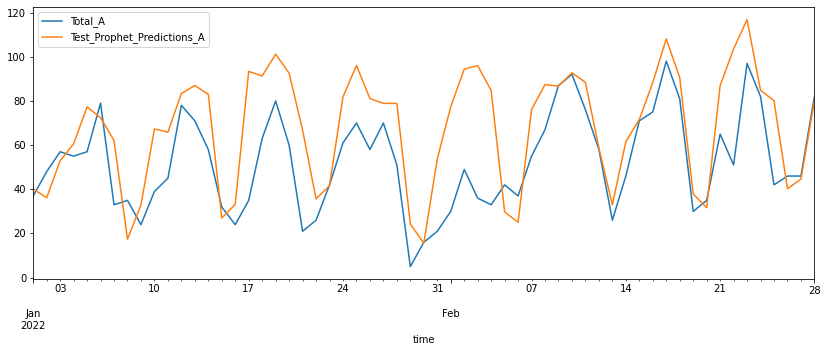

In [141]:
test_prophet_A['Total_A'].plot(figsize=(14,5), legend=True)
prophet_pred_train_A_ex1_2['Test_Prophet_Predictions_A'].plot(legend=True)

<AxesSubplot:xlabel='time'>

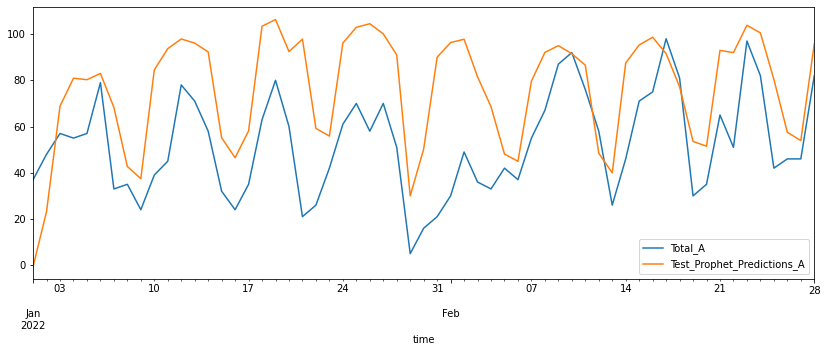

In [142]:
test_prophet_A['Total_A'].plot(figsize=(14,5), legend=True)
prophet_pred_train_A_ex2_2['Test_Prophet_Predictions_A'].plot(legend=True)

<AxesSubplot:xlabel='time'>

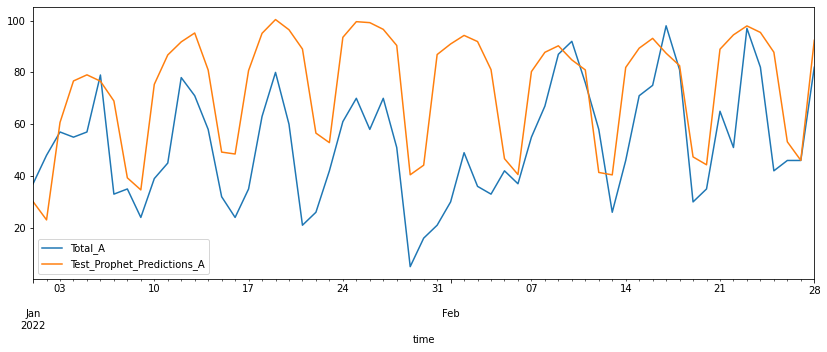

In [143]:
test_prophet_A['Total_A'].plot(figsize=(14,5), legend=True)
prophet_pred_train_A_ex3_2['Test_Prophet_Predictions_A'].plot(legend=True)

--Rückgaben

<AxesSubplot:xlabel='time'>

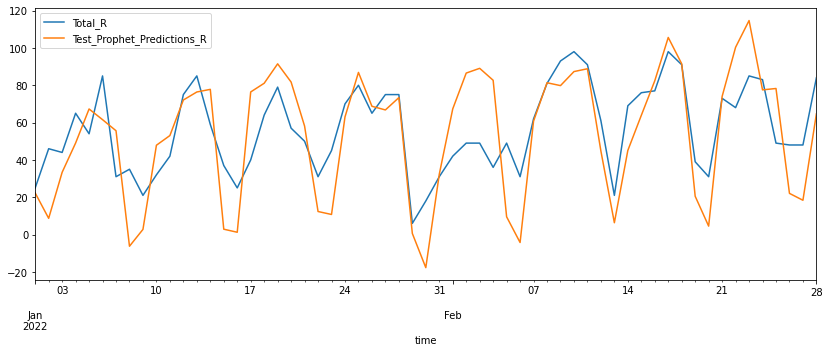

In [144]:
test_prophet_R['Total_R'].plot(figsize=(14,5), legend=True)
prophet_pred_train_R_ex1_2['Test_Prophet_Predictions_R'].plot(legend=True)

<AxesSubplot:xlabel='time'>

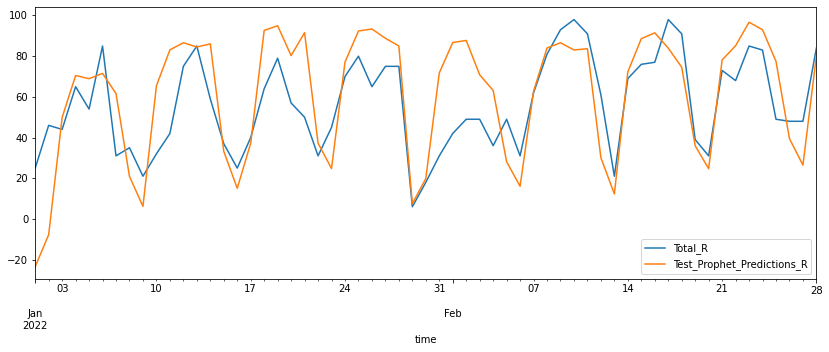

In [145]:
test_prophet_R['Total_R'].plot(figsize=(14,5), legend=True)
prophet_pred_train_R_ex2_2['Test_Prophet_Predictions_R'].plot(legend=True)

<AxesSubplot:xlabel='time'>

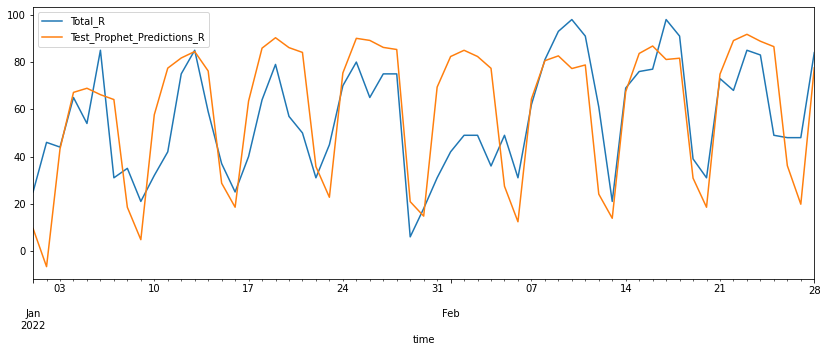

In [146]:
test_prophet_R['Total_R'].plot(figsize=(14,5), legend=True)
prophet_pred_train_R_ex3_2['Test_Prophet_Predictions_R'].plot(legend=True)

---Zusammenführen der Daten von Prophet & ARIMA in einer Tabelle

In [147]:
bike_AP_A = pd.DataFrame()
bike_AP_R = pd.DataFrame()

--Ausleihen

In [148]:
bike_AP_A['Total_A'] = test_arima_A['Total_A']

bike_AP_A['Test_ARIMA_Predictions_A_temp'] = test_arima_A['Test_ARIMA_Predictions_A_temp']
bike_AP_A['Test_Prophet_Predictions_A_temp'] = test_prophet_A['Test_Prophet_Predictions_A_temp']

bike_AP_A['Test_ARIMA_Predictions_A_preci'] = test_arima_A['Test_ARIMA_Predictions_A_preci']
bike_AP_A['Test_Prophet_Predictions_A_preci'] = test_prophet_A['Test_Prophet_Predictions_A_preci']

bike_AP_A['Test_ARIMA_Predictions_A_wind'] = test_arima_A['Test_ARIMA_Predictions_A_wind']
bike_AP_A['Test_Prophet_Predictions_A_wind'] = test_prophet_A['Test_Prophet_Predictions_A_wind']


In [149]:
bike_AP_A.tail()

Total_A  Test_ARIMA_Predictions_A_temp  \
time                                                 
2022-02-24       82                      66.244949   
2022-02-25       42                      56.466216   
2022-02-26       46                      34.805204   
2022-02-27       46                      54.462659   
2022-02-28       82                      57.146766   

            Test_Prophet_Predictions_A_temp  Test_ARIMA_Predictions_A_preci  \
time                                                                          
2022-02-24                        84.780716                       74.180027   
2022-02-25                        80.121793                       49.960100   
2022-02-26                        40.234872                       53.352287   
2022-02-27                        44.645205                       54.272302   
2022-02-28                        79.971947                       62.066984   

            Test_Prophet_Predictions_A_preci  Test_ARIMA_Predictions_A_wind  \
time                                                                          
2022-02-24                        100.528116                      76.810041   
2022-02-25                         80.419425                      64.024224   
2022-02-26                         57.525112                      49.091167   
2022-02-27                         53.925606                      55.013982   
2022-02-28                         95.739233                      65.302670   

            Test_Prophet_Predictions_A_wind  
time                                         
2022-02-24                        95.438031  
2022-02-25                        87.795079  
2022-02-26                        53.201182  
2022-02-27                        46.035654  
2022-02-28                        92.398642

--Rückgaben

In [150]:
bike_AP_R['Total_R'] = test_arima_R['Total_R']

bike_AP_R['Test_ARIMA_Predictions_R_temp'] = test_arima_R['Test_ARIMA_Predictions_R_temp']
bike_AP_R['Test_Prophet_Predictions_R_temp'] = test_prophet_R['Test_Prophet_Predictions_R_temp']

bike_AP_R['Test_ARIMA_Predictions_R_preci'] = test_arima_R['Test_ARIMA_Predictions_R_preci']
bike_AP_R['Test_Prophet_Predictions_R_preci'] = test_prophet_R['Test_Prophet_Predictions_R_preci']

bike_AP_R['Test_ARIMA_Predictions_R_wind'] = test_arima_R['Test_ARIMA_Predictions_R_wind']
bike_AP_R['Test_Prophet_Predictions_R_wind'] = test_prophet_R['Test_Prophet_Predictions_R_wind']

In [151]:
bike_AP_R.tail()

Total_R  Test_ARIMA_Predictions_R_temp  \
time                                                 
2022-02-24       83                      60.317401   
2022-02-25       49                      63.455809   
2022-02-26       48                      29.924902   
2022-02-27       48                      43.918098   
2022-02-28       84                      57.652486   

            Test_Prophet_Predictions_R_temp  Test_ARIMA_Predictions_R_preci  \
time                                                                          
2022-02-24                        77.517840                       71.882857   
2022-02-25                        78.262382                       60.022411   
2022-02-26                        22.071534                       51.876603   
2022-02-27                        18.386267                       46.547856   
2022-02-28                        64.679066                       66.395598   

            Test_Prophet_Predictions_R_preci  Test_ARIMA_Predictions_R_wind  \
time                                                                          
2022-02-24                         93.000334                      72.248459   
2022-02-25                         77.435036                      71.822811   
2022-02-26                         39.476073                      45.509738   
2022-02-27                         26.465556                      43.202540   
2022-02-28                         80.168743                      67.633592   

            Test_Prophet_Predictions_R_wind  
time                                         
2022-02-24                        88.816543  
2022-02-25                        86.536685  
2022-02-26                        36.136462  
2022-02-27                        19.818662  
2022-02-28                        77.583917

---Vergleich von Prophet & ARIMA in einer Grafik mit dem jeweiligen Fehlermaß

--Ausleihen

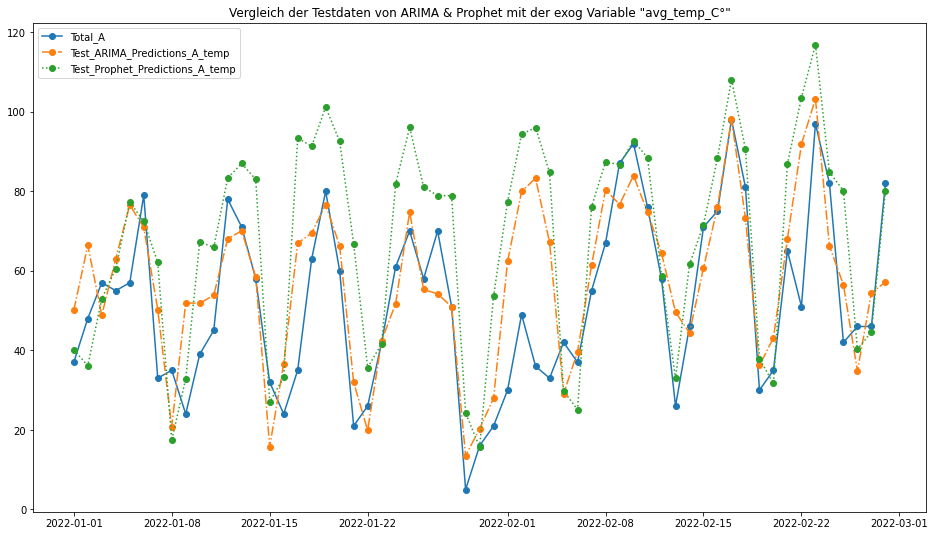

In [152]:
rmse_errors_A_ex1 = [test_arima_rmse_error_A_ex1, test_prophet_rmse_error_A_ex1]
mse_errors_A_ex1 = [test_arima_mse_error_A_ex1, test_prophet_mse_error_A_ex1]
mape_errors_A_ex1 = [test_arima_mape_error_A_ex1, test_prophet_mape_error_A_ex1]
errors_A_ex1 = pd.DataFrame({"Models" : ["ARIMA", "Prophet"],"RMSE Errors" : rmse_errors_A_ex1, "MSE Errors" : mse_errors_A_ex1, 'MAPE Errors': mape_errors_A_ex1})
plt.figure(figsize=(16,9))
plt.plot_date(bike_AP_A.index, bike_AP_A["Total_A"], linestyle="-")
plt.plot_date(bike_AP_A.index, bike_AP_A["Test_ARIMA_Predictions_A_temp"], linestyle="-.")
plt.plot_date(bike_AP_A.index, bike_AP_A["Test_Prophet_Predictions_A_temp"], linestyle=":")
plt.legend(labels=['Total_A', 'Test_ARIMA_Predictions_A_temp', 'Test_Prophet_Predictions_A_temp'])
plt.title('Vergleich der Testdaten von ARIMA & Prophet mit der exog Variable "avg_temp_C°"')
plt.show()

In [153]:
errors_A_ex1

Models  RMSE Errors  MSE Errors  MAPE Errors
0    ARIMA    15.810461  249.970691    11.942141
1  Prophet    23.913839  571.871678    18.097499

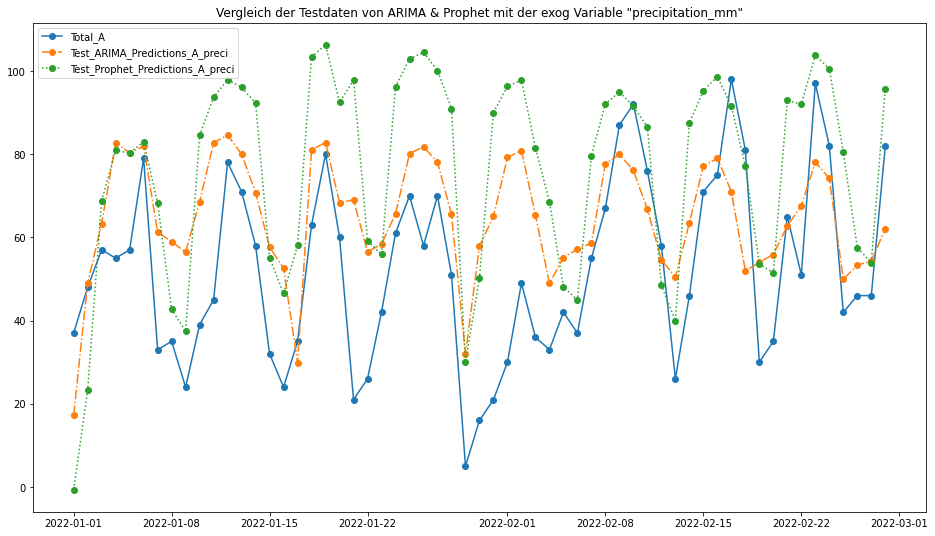

In [154]:
rmse_errors_A_ex2 = [test_arima_rmse_error_A_ex2, test_prophet_rmse_error_A_ex2]
mse_errors_A_ex2 = [test_arima_mse_error_A_ex2, test_prophet_mse_error_A_ex2]
mape_errors_A_ex2 = [test_arima_mape_error_A_ex2, test_prophet_mape_error_A_ex2]
errors_A_ex2 = pd.DataFrame({"Models" : ["ARIMA", "Prophet"],"RMSE Errors" : rmse_errors_A_ex2, "MSE Errors" : mse_errors_A_ex2, 'MAPE Errors': mape_errors_A_ex2})
plt.figure(figsize=(16,9))
plt.plot_date(bike_AP_A.index, bike_AP_A["Total_A"], linestyle="-")
plt.plot_date(bike_AP_A.index, bike_AP_A["Test_ARIMA_Predictions_A_preci"], linestyle="-.")
plt.plot_date(bike_AP_A.index, bike_AP_A["Test_Prophet_Predictions_A_preci"], linestyle=":")
plt.legend(labels=['Total_A', 'Test_ARIMA_Predictions_A_preci', 'Test_Prophet_Predictions_A_preci'])
plt.title('Vergleich der Testdaten von ARIMA & Prophet mit der exog Variable "precipitation_mm"')
plt.show()

In [155]:
errors_A_ex2

Models  RMSE Errors  MSE Errors  MAPE Errors
0    ARIMA    21.803630  475.398301    18.144950
1  Prophet    31.245353  976.272115    26.612114

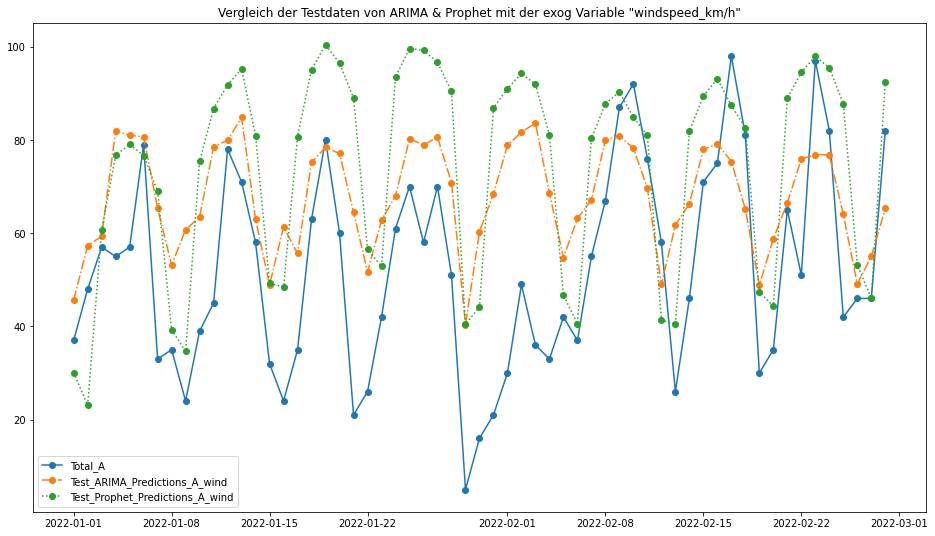

In [156]:
rmse_errors_A_ex3 = [test_arima_rmse_error_A_ex3, test_prophet_rmse_error_A_ex3]
mse_errors_A_ex3 = [test_arima_mse_error_A_ex3, test_prophet_mse_error_A_ex3]
mape_errors_A_ex3 = [test_arima_mape_error_A_ex3, test_prophet_mape_error_A_ex3]
errors_A_ex3 = pd.DataFrame({"Models" : ["ARIMA", "Prophet"],"RMSE Errors" : rmse_errors_A_ex3, "MSE Errors" : mse_errors_A_ex3, 'MAPE Errors': mape_errors_A_ex3})
plt.figure(figsize=(16,9))
plt.plot_date(bike_AP_A.index, bike_AP_A["Total_A"], linestyle="-")
plt.plot_date(bike_AP_A.index, bike_AP_A["Test_ARIMA_Predictions_A_wind"], linestyle="-.")
plt.plot_date(bike_AP_A.index, bike_AP_A["Test_Prophet_Predictions_A_wind"], linestyle=":")
plt.legend(labels=['Total_A', 'Test_ARIMA_Predictions_A_wind', 'Test_Prophet_Predictions_A_wind'])
plt.title('Vergleich der Testdaten von ARIMA & Prophet mit der exog Variable "windspeed_km/h"')
plt.show()

In [157]:
errors_A_ex3

Models  RMSE Errors  MSE Errors  MAPE Errors
0    ARIMA    23.320512  543.846284    19.413845
1  Prophet    29.523753  871.651993    24.137786

--Rückgaben

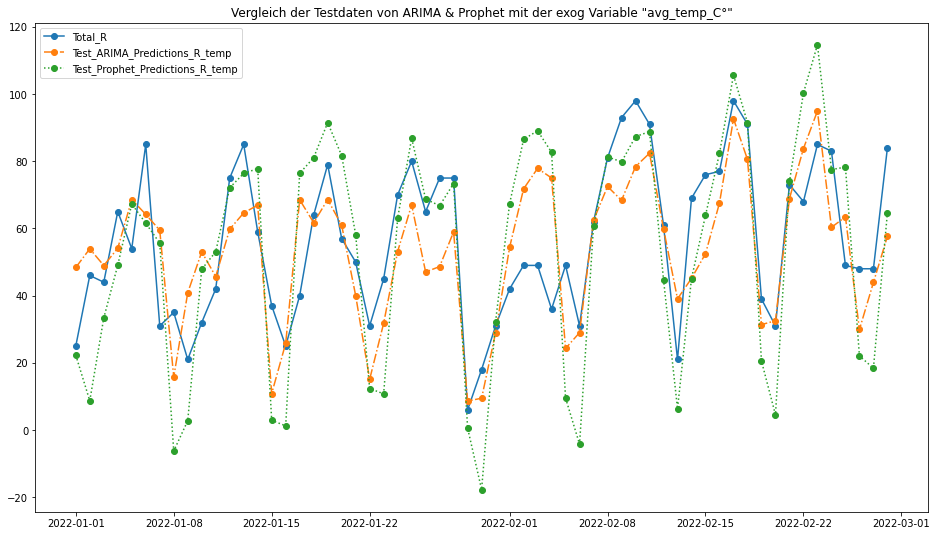

In [158]:
rmse_errors_R_ex1 = [test_arima_rmse_error_R_ex1, test_prophet_rmse_error_R_ex1]
mse_errors_R_ex1 = [test_arima_mse_error_R_ex1, test_prophet_mse_error_R_ex1]
mape_errors_R_ex1 = [test_arima_mape_error_R_ex1, test_prophet_mape_error_R_ex1]
errors_R_ex1 = pd.DataFrame({"Models" : ["ARIMA", "Prophet"],"RMSE Errors" : rmse_errors_R_ex1, "MSE Errors" : mse_errors_R_ex1, 'MAPE Errors': mape_errors_R_ex1})
plt.figure(figsize=(16,9))
plt.plot_date(bike_AP_R.index, bike_AP_R["Total_R"], linestyle="-")
plt.plot_date(bike_AP_R.index, bike_AP_R["Test_ARIMA_Predictions_R_temp"], linestyle="-.")
plt.plot_date(bike_AP_R.index, bike_AP_R["Test_Prophet_Predictions_R_temp"], linestyle=":")
plt.legend(labels=['Total_R', 'Test_ARIMA_Predictions_R_temp', 'Test_Prophet_Predictions_R_temp'])
plt.title('Vergleich der Testdaten von ARIMA & Prophet mit der exog Variable "avg_temp_C°"')
plt.show()

In [159]:
errors_R_ex1

Models  RMSE Errors  MSE Errors  MAPE Errors
0    ARIMA    16.847682  283.844382    14.253395
1  Prophet    22.213345  493.432712    18.201226

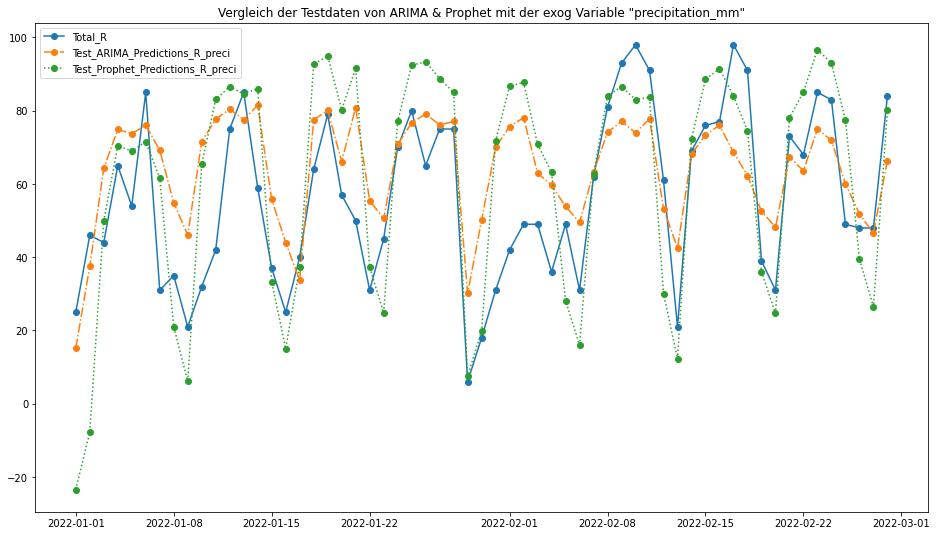

In [160]:
rmse_errors_R_ex2 = [test_arima_rmse_error_R_ex2, test_prophet_rmse_error_R_ex2]
mse_errors_R_ex2 = [test_arima_mse_error_R_ex2, test_prophet_mse_error_R_ex2]
mape_errors_R_ex2 = [test_arima_mape_error_R_ex2, test_prophet_mape_error_R_ex2]
errors_R_ex2 = pd.DataFrame({"Models" : ["ARIMA", "Prophet"],"RMSE Errors" : rmse_errors_R_ex2, "MSE Errors" : mse_errors_R_ex2, 'MAPE Errors': mape_errors_R_ex2})
plt.figure(figsize=(16,9))
plt.plot_date(bike_AP_R.index, bike_AP_R["Total_R"], linestyle="-")
plt.plot_date(bike_AP_R.index, bike_AP_R["Test_ARIMA_Predictions_R_preci"], linestyle="-.")
plt.plot_date(bike_AP_R.index, bike_AP_R["Test_Prophet_Predictions_R_preci"], linestyle=":")
plt.legend(labels=['Total_R', 'Test_ARIMA_Predictions_R_preci', 'Test_Prophet_Predictions_R_preci'])
plt.title('Vergleich der Testdaten von ARIMA & Prophet mit der exog Variable "precipitation_mm"')
plt.show()

In [161]:
errors_R_ex2

Models  RMSE Errors  MSE Errors  MAPE Errors
0    ARIMA    18.680968  348.978579     15.06708
1  Prophet    21.453919  460.270631     16.95080

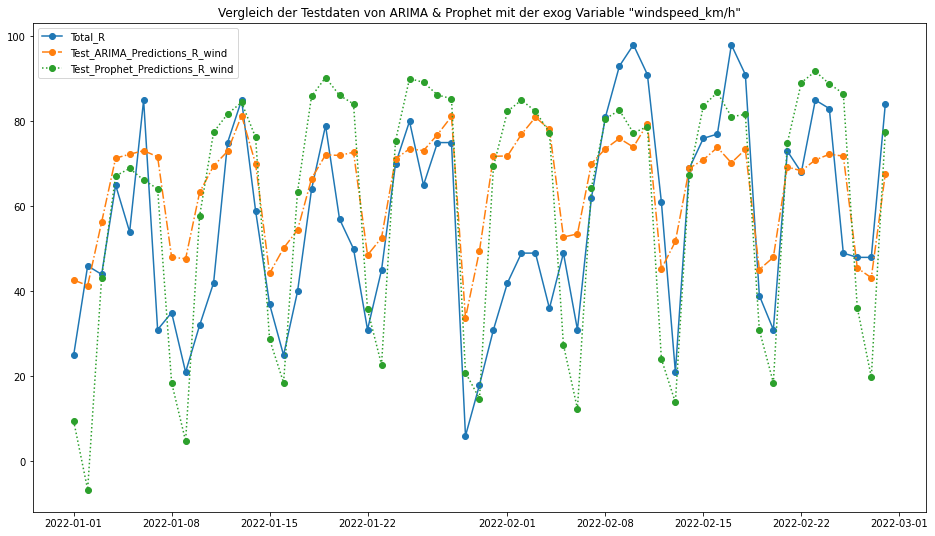

In [162]:
rmse_errors_R_ex3 = [test_arima_rmse_error_R_ex3, test_prophet_rmse_error_R_ex3]
mse_errors_R_ex3 = [test_arima_mse_error_R_ex3, test_prophet_mse_error_R_ex3]
mape_errors_R_ex3 = [test_arima_mape_error_R_ex3, test_prophet_mape_error_R_ex3]
errors_R_ex3 = pd.DataFrame({"Models" : ["ARIMA", "Prophet"],"RMSE Errors" : rmse_errors_R_ex3, "MSE Errors" : mse_errors_R_ex3, 'MAPE Errors': mape_errors_R_ex3})
plt.figure(figsize=(16,9))
plt.plot_date(bike_AP_R.index, bike_AP_R["Total_R"], linestyle="-")
plt.plot_date(bike_AP_R.index, bike_AP_R["Test_ARIMA_Predictions_R_wind"], linestyle="-.")
plt.plot_date(bike_AP_R.index, bike_AP_R["Test_Prophet_Predictions_R_wind"], linestyle=":")
plt.legend(labels=['Total_R', 'Test_ARIMA_Predictions_R_wind', 'Test_Prophet_Predictions_R_wind'])
plt.title('Vergleich der Testdaten von ARIMA & Prophet mit der exog Variable "windspeed_km/h"')
plt.show()

In [163]:
errors_R_ex3

Models  RMSE Errors  MSE Errors  MAPE Errors
0    ARIMA    18.837766  354.861439    15.167645
1  Prophet    21.097225  445.092911    16.988505